In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 


# Decision trees
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from scipy import stats

In [2]:
#read in data from csv file into dataframe
df = pd.read_csv("covid19-cdc-20202492.csv")

# Data Quality and Cleaning

- This section is largely adapted from Assignment 1 with some alterations made due to feedback obtained.

### Changes from Assignment 1
- Duplicate rows are now kept as it is more then likely patients with similar features rather then the same patient being entered multiple times
- More rows are now kept, Missing values are converted to one Unknown value where appropriate
- Race/Ethnicity columns is now kept (Missing values are now converted to Unknown)
- 2 New features from Assignment 1 are kept and will be implemented in part 5. Month of onset is not implimneted as the dataframe only covers January/February this would not have provided much use. Severity is also not implimented as it wouldnt not aid in the prediction of death_yn (it is covered by other features in the data).

## Check how many rows and columns within the file

In [3]:
df.shape



(10000, 12)

Dataset has 10000 entries with 12 features per entry

## Exploring the dataset

In [4]:
df.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/06/04,2020/06/04,2020/06/04,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,No
1,2020/10/23,2020/10/23,NaN,NaN,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,Missing,Missing,No,Missing
2,2020/07/22,2020/10/22,NaN,2020/07/22,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,Missing,No,Missing
3,2020/10/29,2020/11/20,NaN,2020/10/29,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",No,Missing,No,Missing
4,2021/01/01,NaN,NaN,NaN,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",Missing,Missing,No,Missing
5,2020/12/23,2020/12/23,NaN,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",Missing,Missing,No,Missing
6,2021/01/08,2021/01/08,NaN,2021/01/08,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,No,Missing,No,Missing
7,2021/01/02,2021/01/03,NaN,2021/01/03,Laboratory-confirmed case,Male,60 - 69 Years,"White, Non-Hispanic",No,Missing,No,Missing
8,2020/12/21,2020/12/21,NaN,NaN,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",Unknown,Unknown,No,Missing
9,2020/12/18,NaN,NaN,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,No,Missing,No,Missing


In [5]:
df.tail(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
9990,2020/12/10,NaN,NaN,NaN,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Missing,No,Missing
9991,2020/09/02,2020/09/02,NaN,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",No,Missing,No,Missing
9992,2020/11/02,2020/11/10,2020/11/02,2020/11/02,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,Missing,No,Yes
9993,2020/12/02,NaN,NaN,NaN,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,Unknown,Missing,No,Missing
9994,2020/08/16,2020/08/18,2020/08/16,2020/08/16,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",Missing,Missing,No,No
9995,2020/12/27,2020/12/27,NaN,2020/12/27,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Unknown,Missing,No,Missing
9996,2020/10/03,2020/10/03,NaN,NaN,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Missing,No,Missing
9997,2020/12/30,2021/01/03,NaN,2020/12/30,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",No,Missing,No,Missing
9998,2020/11/09,2020/11/09,NaN,2020/11/09,Laboratory-confirmed case,Female,60 - 69 Years,Unknown,No,Missing,No,Missing
9999,2020/11/06,2020/11/08,2020/11/06,NaN,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Missing,Missing,No,Missing


## Get the datatypes for each column

In [6]:
df.dtypes

cdc_case_earliest_dt       object
cdc_report_dt              object
pos_spec_dt                object
onset_dt                   object
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
dtype: object

## Get count, unique entries, top and freq for features

In [7]:
df.describe().T

,count,unique,top,freq
cdc_case_earliest_dt,10000,323,2021/01/04,129
cdc_report_dt,7648,324,2020/06/10,144
pos_spec_dt,2789,314,2021/01/04,34
onset_dt,5059,325,2020/12/08,47
current_status,10000,2,Laboratory-confirmed case,9349
sex,10000,4,Female,5109
age_group,10000,10,20 - 29 Years,1949
race_ethnicity_combined,10000,9,Unknown,4050
hosp_yn,10000,4,No,5152
icu_yn,10000,4,Missing,7710


## Get the unique entries for each feature (except dates would be too long)

In [8]:
obbys = df.select_dtypes(['object']).columns

for i in obbys[4:]:
    print(i,"unique values:",df[i].unique())



current_status unique values: ['Laboratory-confirmed case' 'Probable Case']
sex unique values: ['Female' 'Male' 'Unknown' 'Missing']
age_group unique values: ['30 - 39 Years' '10 - 19 Years' '70 - 79 Years' '40 - 49 Years'
 '60 - 69 Years' '0 - 9 Years' '80+ Years' '50 - 59 Years' '20 - 29 Years'
 'Missing']
race_ethnicity_combined unique values: ['Unknown' 'White, Non-Hispanic' 'Hispanic/Latino'
 'Multiple/Other, Non-Hispanic' 'Black, Non-Hispanic'
 'Asian, Non-Hispanic' 'Missing'
 'American Indian/Alaska Native, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic']
hosp_yn unique values: ['Unknown' 'Missing' 'No' 'Yes']
icu_yn unique values: ['Unknown' 'Missing' 'No' 'Yes']
death_yn unique values: ['No' 'Yes']
medcond_yn unique values: ['No' 'Missing' 'Unknown' 'Yes']


## Get the count for each entry in the categorical datatype (excluding dates)

In [9]:
# get a count for the unique values in the non-date columns
for i in obbys[4:]:
    print("---------------------------")
    print(i)
    print("---------------------------")
    print(df[i].value_counts())

---------------------------
current_status
---------------------------
Laboratory-confirmed case    9349
Probable Case                 651
Name: current_status, dtype: int64
---------------------------
sex
---------------------------
Female     5109
Male       4805
Unknown      80
Missing       6
Name: sex, dtype: int64
---------------------------
age_group
---------------------------
20 - 29 Years    1949
30 - 39 Years    1612
50 - 59 Years    1463
40 - 49 Years    1400
60 - 69 Years    1048
10 - 19 Years    1030
70 - 79 Years     591
0 - 9 Years       455
80+ Years         440
Missing            12
Name: age_group, dtype: int64
---------------------------
race_ethnicity_combined
---------------------------
Unknown                                                 4050
White, Non-Hispanic                                     3230
Hispanic/Latino                                          995
Black, Non-Hispanic                                      749
Multiple/Other, Non-Hispanic          

## get the sum of null entries for each datatype (excluding dates)

In [10]:
df[obbys].isnull().sum()

cdc_case_earliest_dt          0
cdc_report_dt              2352
pos_spec_dt                7211
onset_dt                   4941
current_status                0
sex                           0
age_group                     0
race_ethnicity_combined       0
hosp_yn                       0
icu_yn                        0
death_yn                      0
medcond_yn                    0
dtype: int64

Null for the values reported is not necessarily poor data as pos_spec_dt is date of first positive specimen collection and onset_dt is the date of symptom onset. The absence of data indicates no positive specimen was collected or symptoms manifested

## Convert the dates to datetime

This allows for the spec_before_symptom features to be easily created later

In [11]:
df["cdc_case_earliest_dt"]=pd.to_datetime(df["cdc_case_earliest_dt"],format='%Y/%m/%d')
df["cdc_report_dt"]= pd.to_datetime(df["cdc_report_dt"],format='%Y/%m/%d')
df["pos_spec_dt"]= pd.to_datetime(df["pos_spec_dt"],format='%Y/%m/%d')
df["onset_dt"]= pd.to_datetime(df["onset_dt"],format='%Y/%m/%d')

Check that the conversion was successful

In [12]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
cdc_report_dt              datetime64[ns]
pos_spec_dt                datetime64[ns]
onset_dt                   datetime64[ns]
current_status                     object
sex                                object
age_group                          object
race_ethnicity_combined            object
hosp_yn                            object
icu_yn                             object
death_yn                           object
medcond_yn                         object
dtype: object

## Get descriptive stats for (now) datetime features

In [13]:
df.select_dtypes(include=['datetime64[ns]']).describe().T

,count,unique,top,freq,first,last
cdc_case_earliest_dt,10000,323,2021-01-04,129,2020-01-01,2021-01-16
cdc_report_dt,7648,324,2020-06-10,144,2020-03-08,2021-01-29
pos_spec_dt,2789,314,2021-01-04,34,2020-03-14,2021-01-23
onset_dt,5059,325,2020-12-08,47,2020-01-01,2021-01-28


## Convert features to appropriate data types

In [14]:
continuous_columns = df.select_dtypes(["datetime64[ns]"]).columns

In [15]:
categorical_columns = df.select_dtypes(['object']).columns
for i in categorical_columns:
    df[i] = df[i].astype("category")

In [16]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
cdc_report_dt              datetime64[ns]
pos_spec_dt                datetime64[ns]
onset_dt                   datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
dtype: object

## check for duplicate rows/columns

In [17]:
print('Number of duplicate rows (not including first) in the dataset is: ', df.duplicated().sum())


Number of duplicate rows (not including first) in the dataset is:  465


In [18]:
print('Number of duplicate rows (including first) in the dataset is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate rows (including first) in the dataset is: 841


In [19]:
dfT = df.T
print("Number of duplicate columns (not including first) in the dataset is: ", dfT.duplicated().sum())
print("Number of duplicate columns (including first) in the dataset is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate columns (not including first) in the dataset is:  0
Number of duplicate columns (including first) in the dataset is:  0


### Show duplicated rows, (To get an idea of where/why the duplication is occuring)

In [20]:
df[df.duplicated(keep=False)]

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
40,2020-12-10,NaT,NaT,NaT,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Unknown,Missing,No,Missing
65,2020-12-21,NaT,NaT,NaT,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Missing,Missing,No,Missing
89,2020-12-30,NaT,NaT,NaT,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,Missing,Missing,No,Missing
98,2021-01-06,NaT,NaT,NaT,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Missing,No,Missing
100,2020-12-28,NaT,NaT,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Missing,Missing,No,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...
9907,2021-01-14,NaT,NaT,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Missing,No,Missing
9930,2020-06-22,NaT,NaT,NaT,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,Unknown,Missing,No,Missing
9961,2020-12-28,NaT,NaT,NaT,Laboratory-confirmed case,Female,50 - 59 Years,Unknown,Unknown,Missing,No,Missing
9990,2020-12-10,NaT,NaT,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Missing,No,Missing


In [21]:
df[df.duplicated(keep=False)].tail(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
9857,2021-01-14,NaT,NaT,NaT,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Missing,Missing,No,Missing
9884,2020-12-08,NaT,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,Missing,Missing,No,Missing
9889,2021-01-04,NaT,NaT,NaT,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Missing,Missing,No,Missing
9900,2020-12-29,NaT,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,Missing,Missing,No,Missing
9904,2020-11-17,NaT,NaT,NaT,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,Missing,Missing,No,Missing
9907,2021-01-14,NaT,NaT,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Missing,No,Missing
9930,2020-06-22,NaT,NaT,NaT,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,Unknown,Missing,No,Missing
9961,2020-12-28,NaT,NaT,NaT,Laboratory-confirmed case,Female,50 - 59 Years,Unknown,Unknown,Missing,No,Missing
9990,2020-12-10,NaT,NaT,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Missing,No,Missing
9993,2020-12-02,NaT,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,Unknown,Missing,No,Missing


Upon further inspection it appears that the duplicate rows are the result of Missing/Unknown/Null values for the majority of columns and not the same patient being entered repeatedly

### See if the duplicate rows have any positive instances of the target feature

In [22]:
duplicate_df = df[df.duplicated(keep=False)]

(duplicate_df["death_yn"] == "Yes").sum()

0

There are no duplicate columns where the entry has died. This combined with the logic above indicates that keeping the duplicate rows would be appropriate

## Check for constant columns

In [23]:
df.select_dtypes(["category"]).describe().T

,count,unique,top,freq
current_status,10000,2,Laboratory-confirmed case,9349
sex,10000,4,Female,5109
age_group,10000,10,20 - 29 Years,1949
race_ethnicity_combined,10000,9,Unknown,4050
hosp_yn,10000,4,No,5152
icu_yn,10000,4,Missing,7710
death_yn,10000,2,No,9651
medcond_yn,10000,4,Missing,7554


All category data have more than 1 unique value, there are no constant columns, so their inclusion going forward is appropriate

## Descriptive Statistics for Continuous Features

### Show range and the 50 most common entries for Continuous features

In [24]:
for i in continuous_columns:
    print("\033[1m"+"********************\n")
    print(i)
    print("-------------------------\n" + "\033[0m")
    print("Date range for {} is: ".format(i), (df[i].max() - df[i].min()))
    print("-------------------------")
    print("Date", "\t   Number of Cases \n")
    print(df[i].value_counts().nlargest(50), "\n\n\n")
    print("Null Values: ",df[i].isna().sum())

********************

cdc_case_earliest_dt
-------------------------

Date range for cdc_case_earliest_dt is:  381 days 00:00:00
-------------------------
Date 	   Number of Cases 

2021-01-04    129
2021-01-05    116
2020-12-28    112
2020-12-29    110
2021-01-06    108
2021-01-11    102
2020-12-30    102
2020-12-07     98
2020-12-01     97
2020-12-14     97
2020-12-21     97
2020-12-18     97
2020-12-17     95
2020-12-08     93
2020-12-22     93
2020-12-09     89
2021-01-13     87
2020-12-23     87
2020-12-10     87
2020-11-30     85
2020-12-15     84
2020-12-16     82
2021-01-08     81
2020-12-02     81
2020-12-11     79
2021-01-12     78
2020-12-31     76
2020-12-03     73
2020-11-17     73
2020-12-04     72
2021-01-15     72
2020-11-25     72
2021-01-07     71
2020-11-10     71
2020-12-12     70
2020-11-28     69
2020-12-26     67
2020-12-24     67
2020-11-23     66
2020-11-16     66
2020-12-19     65
2021-01-14     64
2020-12-06     64
2020-11-20     64
2020-11-06     63
2020-11-

## Histograms for continous features

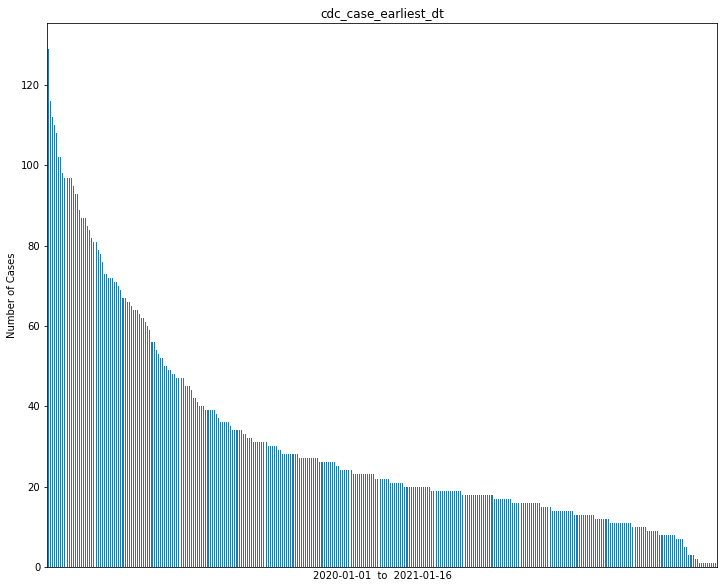

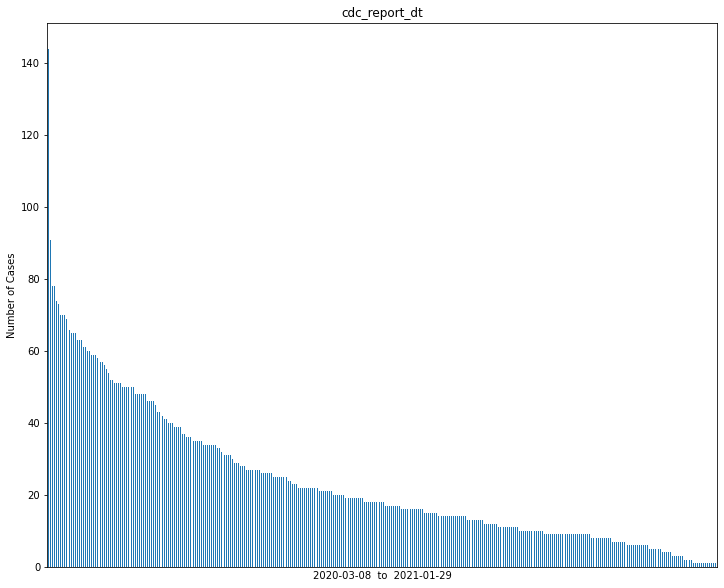

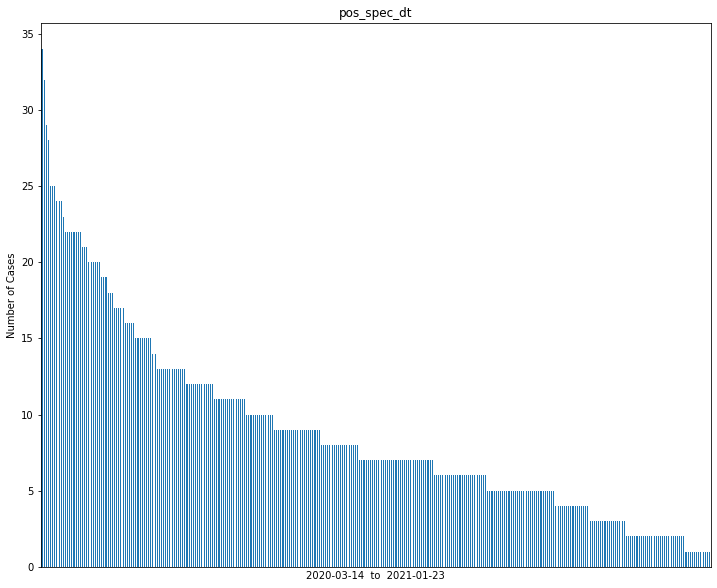

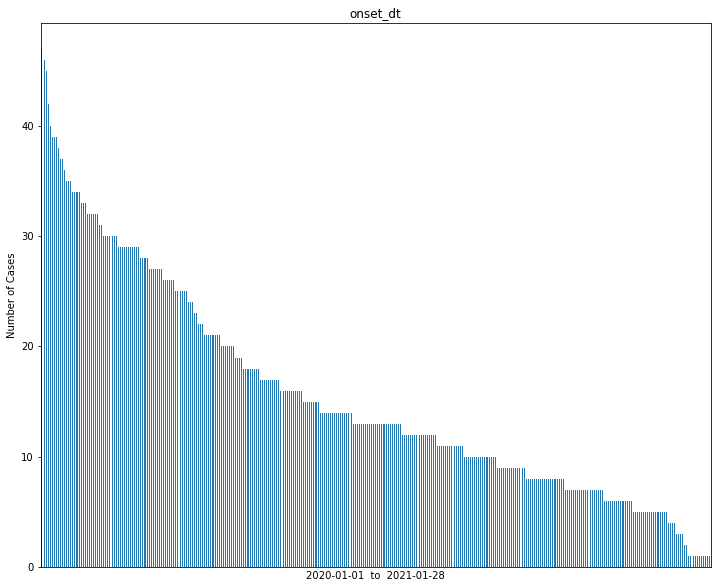

In [25]:

for i in continuous_columns:
    p = df[i].value_counts().plot(kind="bar" , figsize=(12,10))
    plt.title(i)
    plt.ylabel("Number of Cases")
    date_range=str(df[i].min().date()) + "  to  " + str(df[i].max().date())
    plt.xlabel(date_range)
    plt.xticks([])
    plt.savefig("continuous_histogram_"+i+".pdf")
    plt.show()

### Boxplots for Continous features/frequency

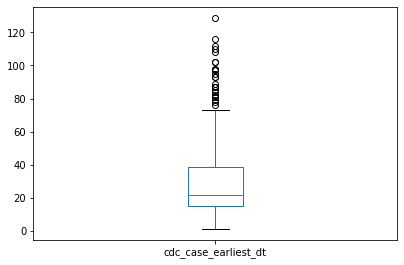

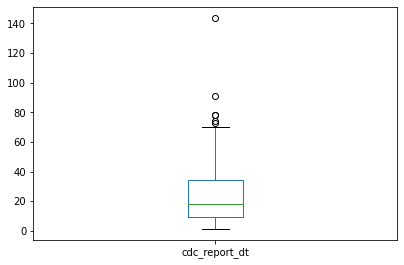

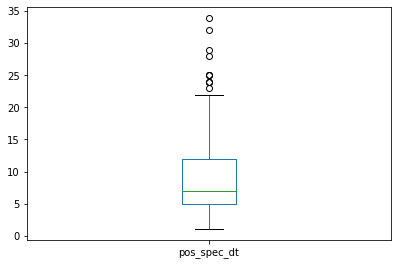

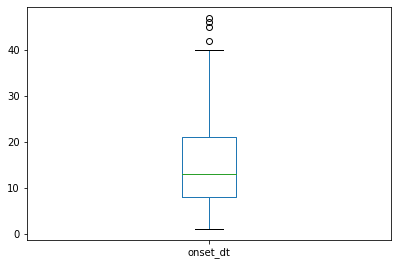

In [26]:
for i in continuous_columns:
    df[i].value_counts().plot(kind='box', subplots=True, figsize=(30,30), layout=(6,4), sharex=False, sharey=False)
    plt.savefig("continous_boxplot_frequency_"+i+".pdf")
    plt.show()


## Prepare a table with descriptive statistics for all the categorical features.

In [27]:
categorical_columns = df.select_dtypes(["category"]).columns
cat_feat_to_save = df[categorical_columns].describe().T

## Create Barcharts for all categorical features

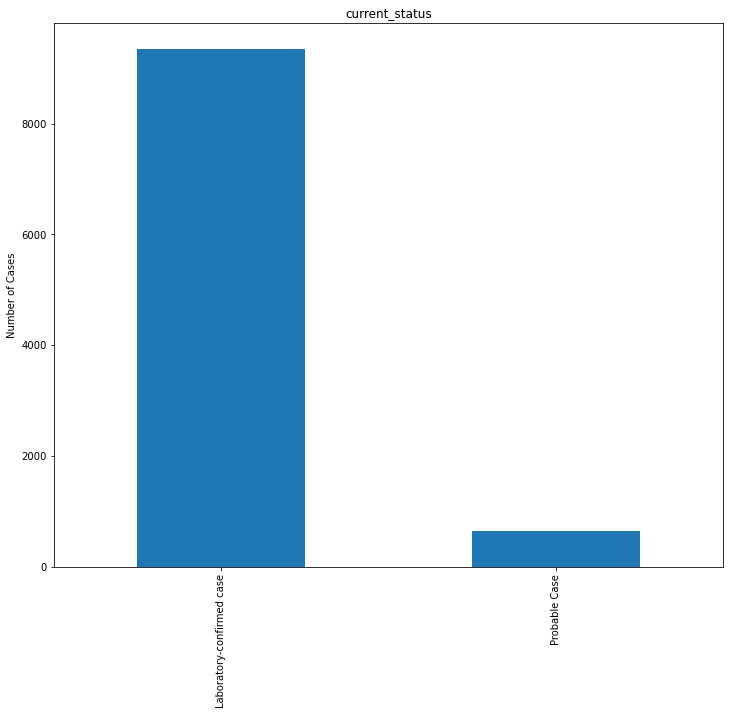

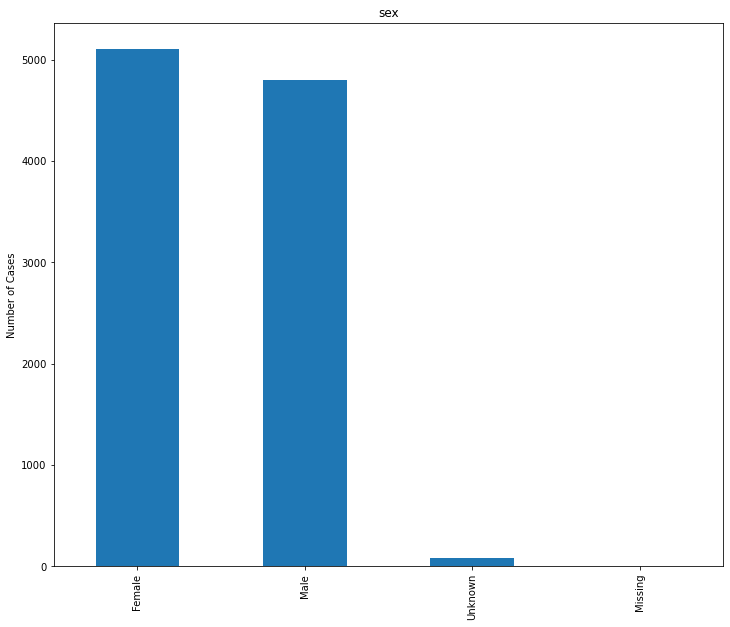

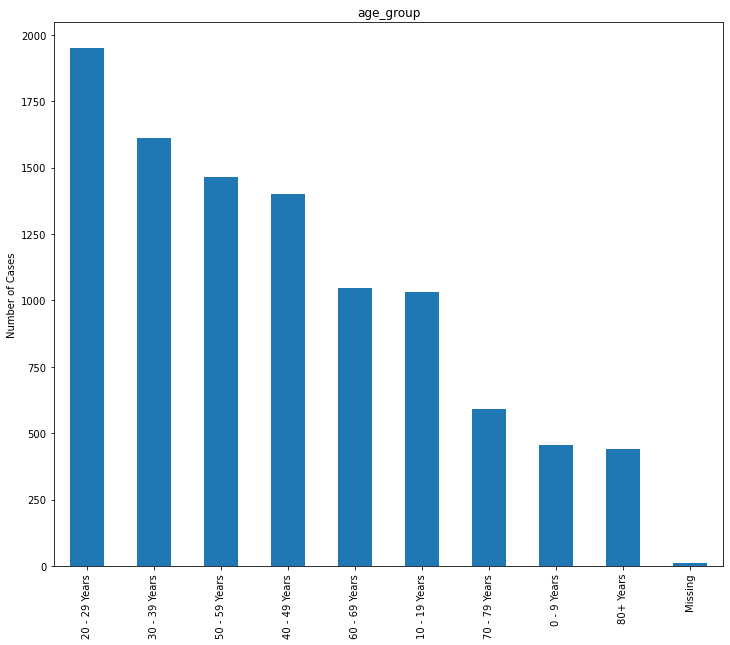

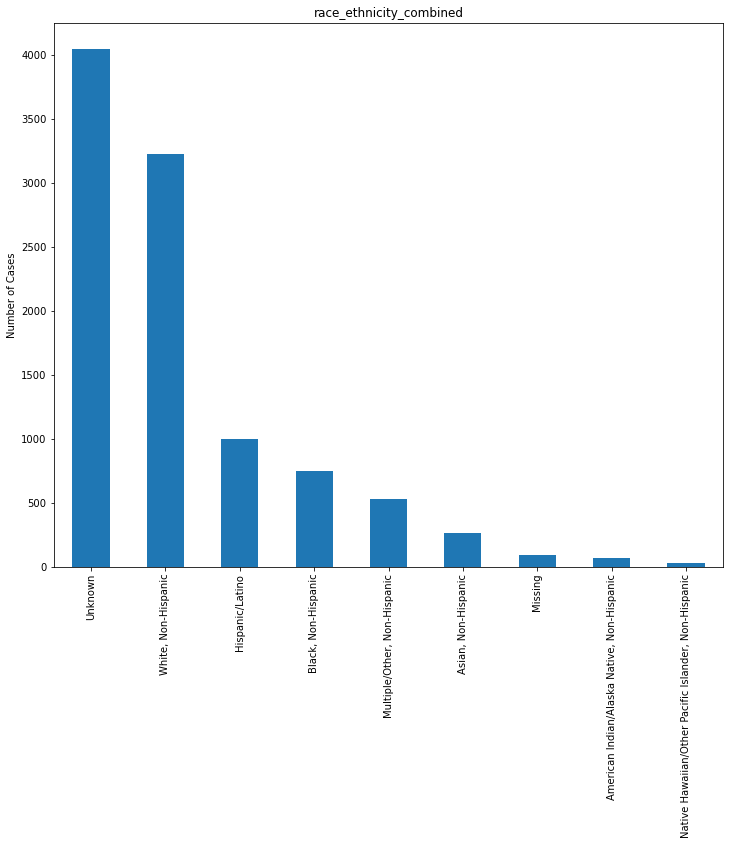

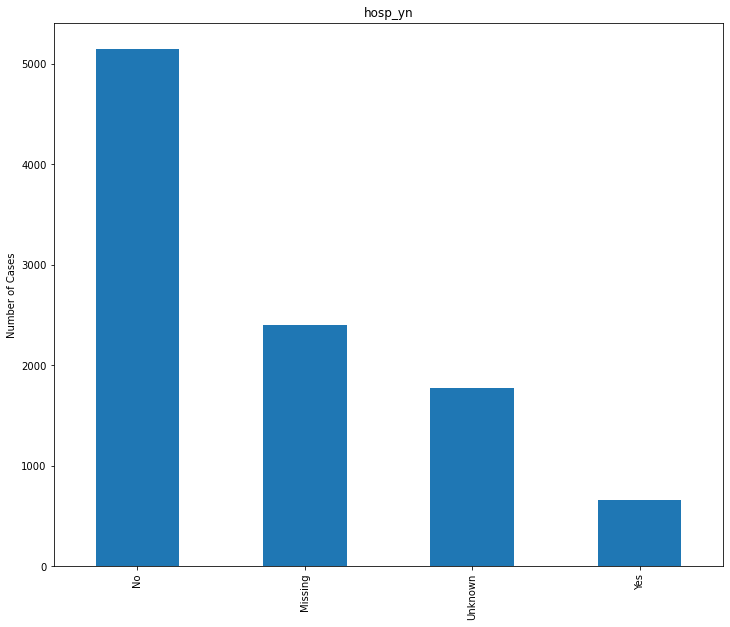

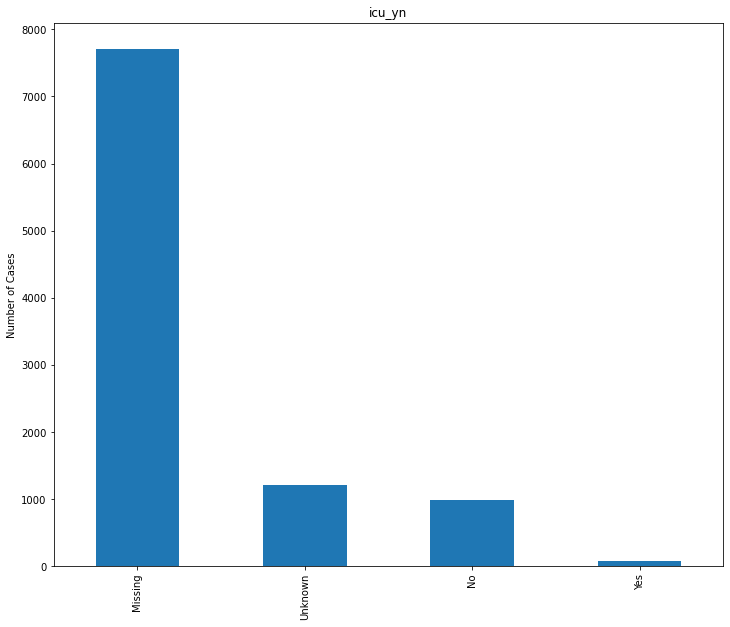

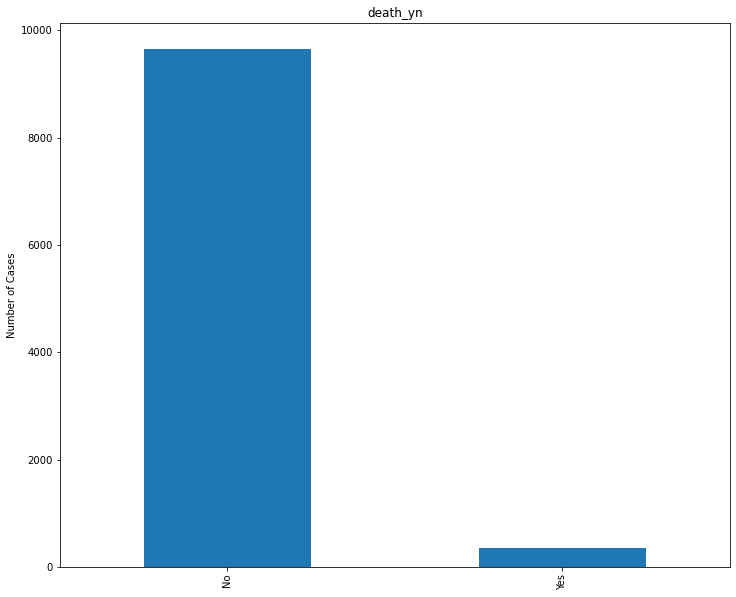

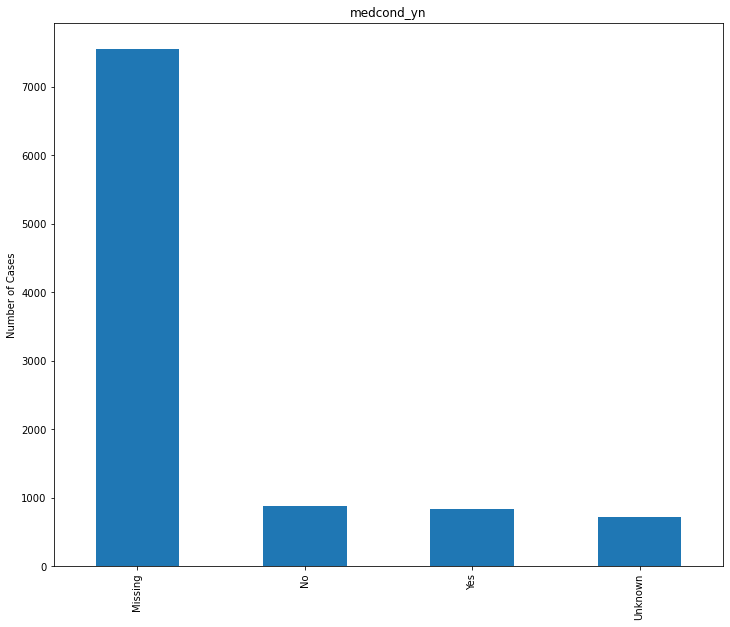

In [28]:
for i in categorical_columns:
    p = df[i].value_counts().plot(kind="bar" , figsize=(12,10))
    plt.title(i)
    plt.ylabel("Number of Cases")
    plt.savefig("categorical_barchart_"+i+".pdf")
    plt.show()

## Issues found from the barcharts
- Missing value for sex
- Missing values for age
- Missing value for medcondition
- Unknown most common value for race/ethnicity


### Find the sum of the problematic entries

In [29]:
# Sum of entries where value of sex feature is Missing
(df["sex"] == "Missing").sum()

6

In [30]:
# Sum of entries where value of hosp_yn feature is Unknown
(df["hosp_yn"]=="Unknown").sum()

1780

In [31]:
# Sum of entries where value of icu_yn feature is Unknown
(df["icu_yn"]=="Unknown").sum()

1220

In [32]:
# Sum of entries where value of icu_yn feature is Unknown and hosp_yn isnt unknown
((df["icu_yn"] == "Unknown") & (df["hosp_yn"] != "Unknown")).sum()

710

In [33]:
# Sum of entries where value of icu_yn feature isnt Unknown and hosp_yn is unknown
((df["icu_yn"] != "Unknown") & (df["hosp_yn"] == "Unknown")).sum()

1270

## Logical consistency

Sum the rows where icu status is yes but hosp status is missing or unknown

In [34]:
((df["icu_yn"] == "Yes") & (df["hosp_yn"] == "Missing")).sum()



0

In [35]:
((df["icu_yn"] == "Yes") & (df["hosp_yn"] == "Unknown")).sum()

0

No rows found with positive icu status and unknown/missing hosp status. This allows us to infer that the missingvalues for hospital admission are the equivalent of a NULL value, as cases cannot be in the ICU without first going to the hospital.

In [36]:
((df["icu_yn"] == "Unknown") & (df["hosp_yn"] == "Unknown")).sum()

510

In [37]:
((df["icu_yn"] == "Missing") & (df["hosp_yn"] == "Yes")).sum()

301

In [38]:
((df["icu_yn"] == "Missing") & (df["hosp_yn"] == "No")).sum()

3754

Based on these values it would be safe to assume that Missing for the icu_yn is the equvalent to a No value.
as Missing for icu is much greater when hosp_yn is No (where icu would also be a no).

## Check cardinality for continuous features

In [39]:

features_cardinality = list(df[continuous_columns].columns.values)

print('{0:35}  {1}'.format("Feature", "Cardinality"))
print('{0:35}  {1}'.format("-------", "--------------- \n"))

for i in features_cardinality:
    print('{0:35}  {1}'.format(i, str(len(df[i].unique()))))

Feature                              Cardinality
-------                              --------------- 

cdc_case_earliest_dt                 323
cdc_report_dt                        325
pos_spec_dt                          315
onset_dt                             326


# Data Quality plan

## The initial issues identified within the data
- Duplicate rows, these will be kept for reasons outlined previously
- Missing and unknown values in sex
- Missing ICU data
- Race and ethniciy column, Nearly 50% of the data is missing or unknown
- Missing data in age_group
- Missing and unknown data in medcond
- Unknown hospital values
- Unknown ICU values



## Proposed Solutions

1. *Duplicate rows*
* These rows will be kept as analysis of the content indicates that these are patients with similar features and not multiple entries for the same patient

2. *Missing unknown & Other Sex*
 * As these rows make up a very small percentage of the overall data these can be safely dropped with little to no impact. There is no predictive value on the target as Unknown and Missing are errors within the data collection (e.g There is little value is showing the percentage of death among the Unknown sex as that doesnt exist).
 
 * As there is comparable few entries with Other as a value this will be dropped as there is no logical conversion possible and there is little predictive value with only one entry (too few entries with unknown to be a good sample to base a model from)
 


3. *Missing ICU data*
 * Based on the included form (pui-form.pdf) it can be safe to assume that missing in this instance means that the appropriate areas on the form were not completed. This can then be taken to defaulting to No as a result of user error (Leaving it blank rather then marking no). Conversion to No is then appropriate

4. *Race and ethnicity Column*
 * as Unknown or Missing makes up nearly half of the data for this column, these will be combined into one unknown value.
 
 * This was chosen to allow for data analysis based on Race/ethnicity


5. *Missing age_group*
* As these rows make up a very small percentage of the overall data these can be safely dropped with little to no impact

* there would be no use in leaving the data in as a predictor of the target as Missing is a data error and not a valid category

* There is also no other column with which to infer the correct age_group so conversion would not be appropriate either

6. *Missing and unknown data in medcond*
 * Rows with the "Unknown" value will be kept as an unknown vale indicator.
 
* Based on the included form (pui-form.pdf) it can be safe to assume that missing in this instance means that the appropriate areas on the form were not completed. Therefore it would be appropriate to convert these to "No"

7. *"Unknown" value for hospital*
 * These rows will be kept as an unknown value indicator


8. *"Unknown" value for ICU*
 * These rows will be kept as an unknown value indicator
 




## Missing and unknown sex values

In [40]:
# Replace Missing and unknown in the Sex feature with a dummy value "A"
# This was the only way to get rid of the values categories from the charts, dont know why this works. CS support centre has no idea why this works, But it does so im rolling with it
df["sex"].replace({"Missing":"A"},inplace=True)
df["sex"].replace({"Unknown":"A"},inplace=True)
df["sex"].replace({"Other":"A"},inplace=True)


# include only the rows where sex does not equal the A dummy value
df = df[df.sex != "A"]


### Missing ICU data

In [41]:
#Replaces instances of "Missing" in icu_yn with "No"
df["icu_yn"].replace({"Missing":"No"},inplace=True)

### Race and ethnicity column

In [42]:
#Converts the missing values in race/ethnicity with a single Unknown value 
df["race_ethnicity_combined"].replace({"Missing":"Unknown"},inplace=True)

### Missing age_group

In [43]:
# Change missing value in the age_group column to a dummy value "A", again this was the only way to prevent further issues with charts
df["age_group"].replace({"Missing":"A"},inplace=True)
df = df[df.age_group != "A"]

### Missing and Unknown data for medcond_yn

In [44]:
print("Values to change",np.sum(df["medcond_yn"]=="Missing"))

Values to change 7461


In [45]:
#Replace values
df["medcond_yn"].replace({"Missing":"No"},inplace=True)

In [46]:
# Give the first 10 entries a check just to make sure its all working OK
df.head(10)

# have a little cheer because my god this has gone wrong a lot

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-06-04,2020-06-04,2020-06-04,NaT,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,No
1,2020-10-23,2020-10-23,NaT,NaT,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,Missing,No,No,No
2,2020-07-22,2020-10-22,NaT,2020-07-22,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,No,No,No
3,2020-10-29,2020-11-20,NaT,2020-10-29,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",No,No,No,No
4,2021-01-01,NaT,NaT,NaT,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",Missing,No,No,No
5,2020-12-23,2020-12-23,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",Missing,No,No,No
6,2021-01-08,2021-01-08,NaT,2021-01-08,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,No,No,No,No
7,2021-01-02,2021-01-03,NaT,2021-01-03,Laboratory-confirmed case,Male,60 - 69 Years,"White, Non-Hispanic",No,No,No,No
8,2020-12-21,2020-12-21,NaT,NaT,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",Unknown,Unknown,No,No
9,2020-12-18,NaT,NaT,NaT,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,No,No,No,No


### Unknown values for hospital

In [47]:
print("Values to change",np.sum(df["hosp_yn"]=="Missing"))

Values to change 2362


In [48]:
# Change missing values
df["hosp_yn"].replace({"Missing":"No"},inplace=True)

# And now for the Actual Assignment 2 portion

(1). [25] Data Understanding and Preparation: Exploring relationships between feature pairs and selecting/transforming promising features based on a given training set.

- (1.1) Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. For shuffling, please remember to set the random state so the split is always the same, this helps with reproducing and verifying your results.
- (1.2) On the training set:
    - Plot the correlations between all the continuous features (if any). Discuss what you observe in these plots.
    - For each continuous feature, plot its interaction with the target feature (a plot for each pair of   continuous feature and target feature). Discuss what you observe from these plots, e.g., which continuous features seem to be better at predicting the target feature? Choose a subset of continuous features you find promising (if any). Justify your choices.
    - For each categorical feature, plot its pairwise interaction with the target feature. Discuss what  knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? Choose a subset of categorical features you find promising (if any). Justify your choices.

### ( 1. 1 ) Shuffling and Splitting the Dataset

In [49]:
df.shape

(9902, 12)

In [50]:
# Shuffling it with a static state to keep it consistent
df = sklearn.utils.shuffle(df,random_state=69)

In [51]:
# Splitting into a training and test
df_training=df.iloc[:int(df.shape[0]*.7), :]
df_test=df.iloc[int(df.shape[0]*.7):,:]

Checking the shape of the two dataframes

In [52]:
df_training.shape


(6931, 12)

In [53]:
df_test.shape

(2971, 12)

Looking well

## Plotting the Correlations between all the continous features

No continous features in the current dataset. However a new continous feature is introduced later in part 5 and the correlation will be calculated and outlined there

## Plotting the pairwise interaction of categorical features and the target feature


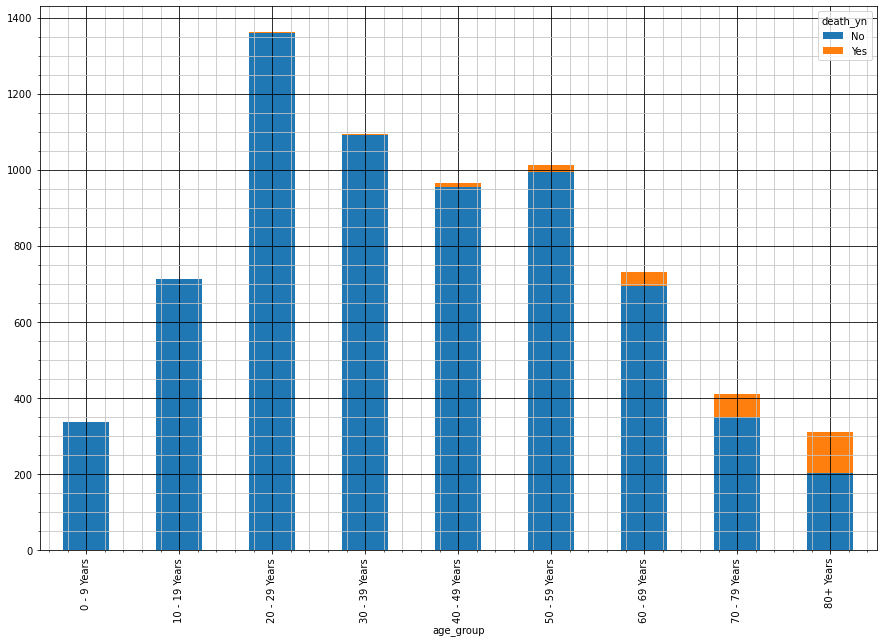

In [64]:
by_age= df_training.groupby(["age_group","death_yn"]).size()
by_age.unstack().plot(kind="bar",stacked = True, figsize=(15,10))

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)



Here we can see the stacked bar plot for age groups against the target outcome death status

- There is a clear indication of an increase risk of death with an increase in age
- This indicates that an individual is at a greater risk of death due to COVID 19 if they are above the age of 50 with the greatest risk at the 80+ group

This is consistant with what we already know about how covid-19 affects populations and comes as no great suprise, however it is interesting that no deaths were recorded for the agegroups under 19.

(0.0, 1.0)

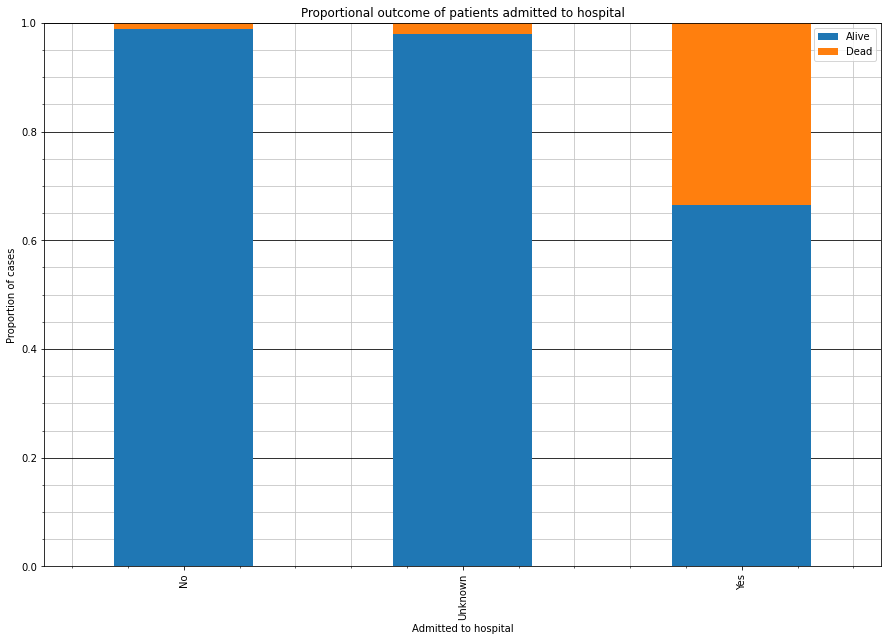

In [65]:
by_hospital=df_training.groupby(["hosp_yn"]).death_yn.value_counts(normalize=True)
#by_hospital
by_hospital_plot =by_hospital.unstack().plot(kind="bar",stacked = True, figsize=(15,10), title="Proportional outcome of patients admitted to hospital")
# add x and y labels
by_hospital_plot.set_ylabel("Proportion of cases")
by_hospital_plot.set_xlabel("Admitted to hospital")

# add legend labels
by_hospital_plot.legend(["Alive","Dead"])

#add gridlines

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)
plt.ylim(0,1)



Above is the stacked bar plot for hospital admission status against the target outcome death status
- There is a clear indication of an increased in deaths with regards to hospital admissions
- approx 1% of cases not admitted to the hospital resulted in death 
- approx 38% of cases admitted to the hospital resulted in death

This figure is not suprising as a case that is admitted to the hospital is going to be more serious then a case that is not (correlation is not causation).

(0.0, 1.0)

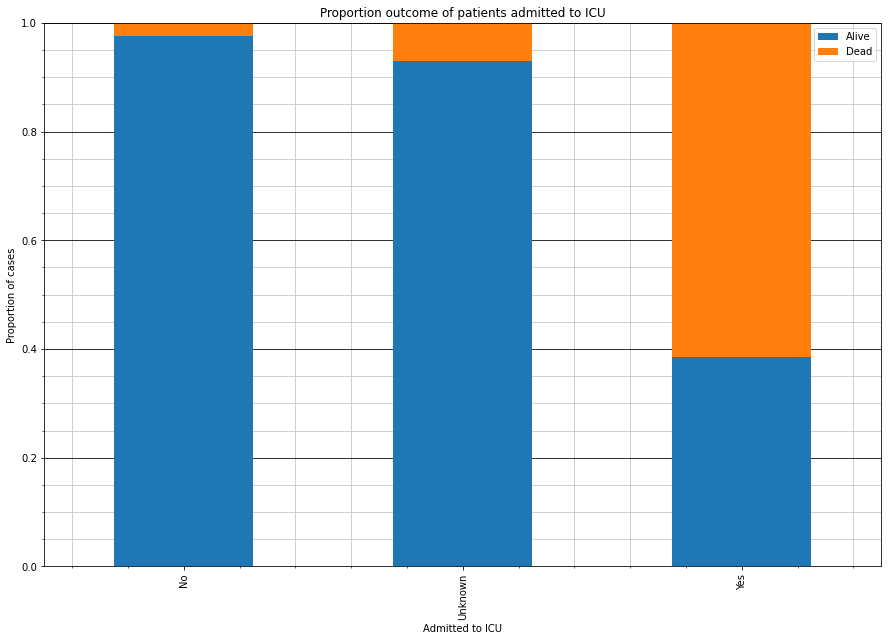

In [66]:
by_icu = df_training.groupby(["icu_yn"]).death_yn.value_counts(normalize=True)
by_icu
by_icu_plot=by_icu.unstack().plot(kind="bar",stacked = True, figsize=(15,10), title="Proportion outcome of patients admitted to ICU")
by_icu_plot.set_ylabel("Proportion of cases")
by_icu_plot.set_xlabel("Admitted to ICU")
by_icu_plot.legend(["Alive","Dead"])


plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)
plt.ylim(0,1)



Here we see the stacked barchart for ICU admissions and Death

- Again there is a much higher proportion of deaths in cases that are admitted to the ICU

This is consistant with the hospital findings as a case that is admitted to the ICU is going to be more serious then a case not. However the proportion is suprising with almost half of ICU cases resulting in death. This indicates that once the virus has become this serious the patient outlook is not good

(0.0, 1.0)

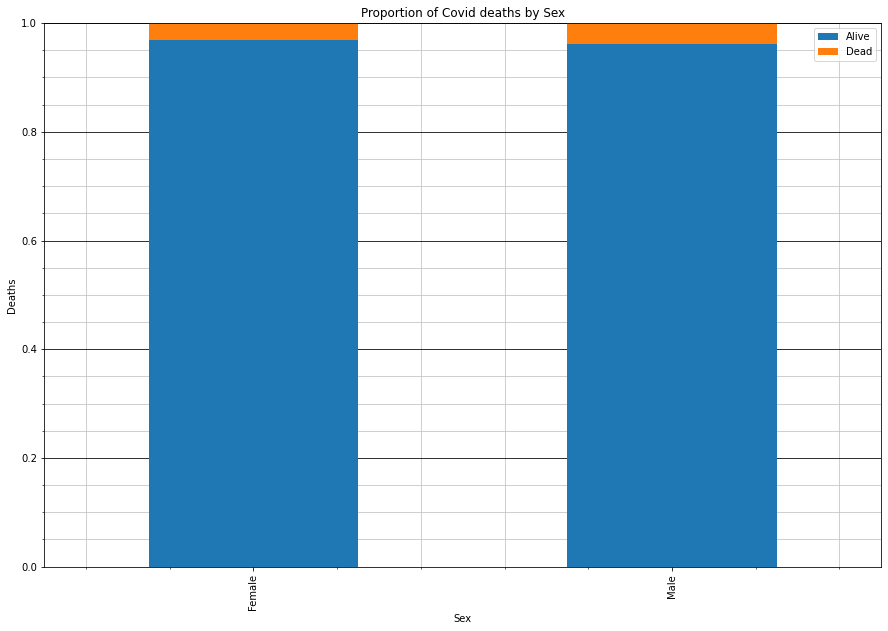

In [67]:
by_sex= df_training.groupby(["sex"]).death_yn.value_counts(normalize=True)

by_sex_plot=by_sex.unstack().plot(kind="bar",stacked = True, figsize=(15,10), title="Proportion of Covid deaths by Sex")


by_sex_plot.set_ylabel("Proportion of cases")
by_sex_plot.set_xlabel("Sex")

by_sex_plot.legend(["Alive","Dead"])

by_sex_plot.set_ylim([0,1])

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)
plt.xlabel("Sex")
plt.ylabel("Deaths")
plt.ylim(0,1)



Here we see the stacked barchart of sex and death.

- There appears to be no significant difference in the target outcome with regards to Sex, There is slightly greater proportion of deaths in the male group but not a large amount



(0.0, 1.0)

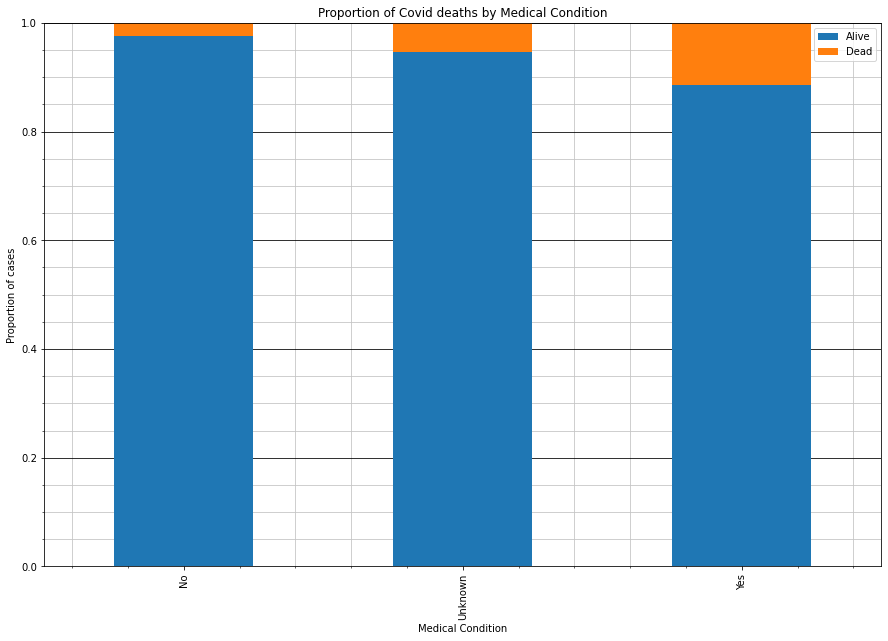

In [68]:

by_medcon= df_training.groupby(["medcond_yn"]).death_yn.value_counts(normalize=True)

by_medcon_plot=by_medcon.unstack().plot(kind="bar",stacked = True, figsize=(15,10), title="Proportion of Covid deaths by Medical Condition")

by_medcon_plot.set_ylabel("Proportion of cases")
by_medcon_plot.set_xlabel("Medical Condition")

by_medcon_plot.legend(["Alive","Dead"])

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)
plt.ylim(0,1)



Here we see the stacked barchart for covid deaths and pre-existing medical conditions

- as shown the proportion of deaths in the group with conditions higher

This again is not suprising as government and healthcare agencies advice is those with pre existing conditions are much more suseptible to the virus. For future research is would be intresting to see how the type of condition affects outcome (e.g respitory etc etc).



(0.0, 1.0)

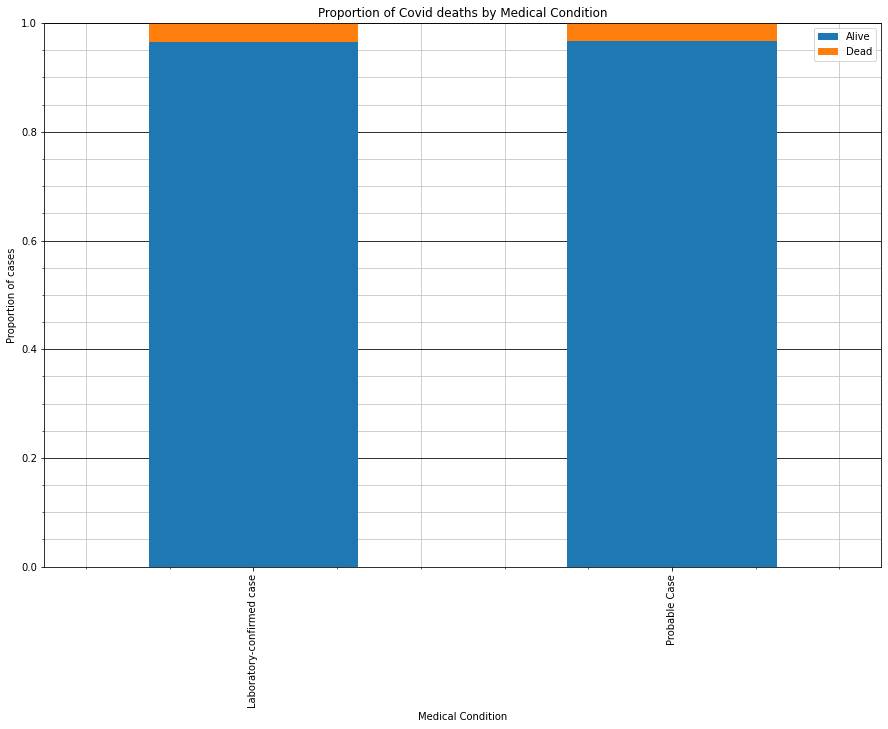

In [69]:

by_status= df_training.groupby(["current_status"]).death_yn.value_counts(normalize=True)

by_status_plot=by_status.unstack().plot(kind="bar",stacked = True, figsize=(15,10), title="Proportion of Covid deaths by Medical Condition")

by_status_plot.set_ylabel("Proportion of cases")
by_status_plot.set_xlabel("Medical Condition")

by_status_plot.legend(["Alive","Dead"])

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)
plt.ylim(0,1)



Here we see the stacked barchart for covid deaths and status of cases

- There is little significant difference between the groups but the Labrotory-confirmed cases have a slightly higher proportion of deaths

This could be due to individuals with a labratory confirmed case already being more at risk and thus more likely to be properly tested

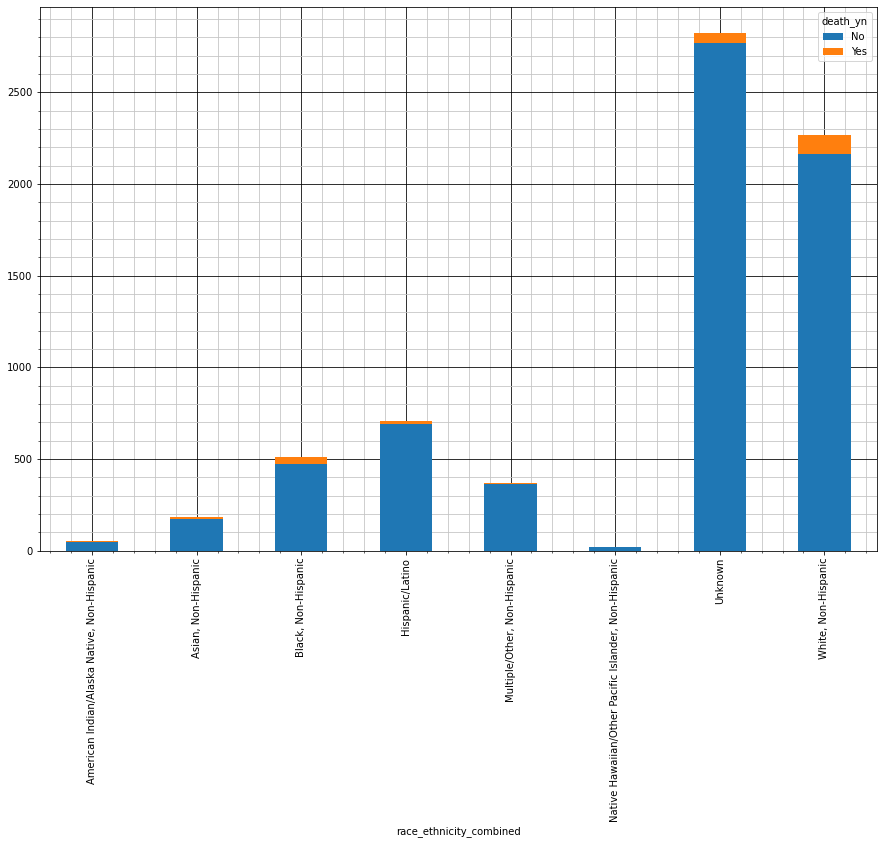

In [70]:
by_race= df_training.groupby(["race_ethnicity_combined","death_yn"]).size()
by_race.unstack().plot(kind="bar",stacked = True, figsize=(15,10))

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)



Above is a stacked bar chart showing the interaction between Race/ethnicity combined and the target feature.

The bar chart shows a clear difference in the proportion of deaths between the groups.

White, Non-Hispanic has the greatest proportion of deaths. Multiple/Other appears to have the least amount of deaths and there appears to be no deaths in the Multiple, Native Hawaiin/Other pacific islander and American Indian/Alaska Native groups

# Features that seem to predict the target variable and will be used in the prediction models



Categorical Features
- Admitted to the ICU, Much greater proportion of deaths in the postive category
- Admitted to the Hospital, again much greater proportion of deaths in the positive category
- Age group had an increase in death as the age group increases
- Race ethnicity combined, greater proportion of deaths among non-hispanic whites
- Medical condition showed a slightly greater proportion of deaths among those with pre-existing medical conditions

These features were chosen to be included in the predictions going forward as they appear to have the greatest correlation with the target feature.

Sex and Current Status showed no large difference in target feature proportion between the categories and so will not be used in the prediction models.

# Part 2

(2). [15] **Predictive Modeling:** Linear Regression.  

    - (2.1) On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. 
    - (2.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).    
    - (2.3) Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
    - (2.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

In [71]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [72]:
# This feature is used to compute the classification metrics
def printClassMetrics(testActualVal, predictions):
    print('\n==============================================================================')
    print("Confusion Matrix: ", metrics.confusion_matrix(testActualVal, predictions))
    print("Accuracy: ", metrics.accuracy_score(testActualVal, predictions))
    print("Precision Score ", metrics.precision_score(testActualVal, predictions , pos_label="Dead"))
    print("F1", metrics.f1_score(testActualVal, predictions, pos_label="Dead"))
    print("Recall Score", metrics.recall_score(testActualVal, predictions, pos_label="Dead"))


In [73]:
#Categorical features
pred_features_catg=["age_group","icu_yn","hosp_yn","medcond_yn","race_ethnicity_combined"]

## One Hot encoding for Categorical features

### Age_group

In [74]:
age_dummies=pd.get_dummies(df_training["age_group"],prefix="age",drop_first=True)
print("Age group dummies.\n",age_dummies)

Age group dummies.
       age_10 - 19 Years  age_20 - 29 Years  age_30 - 39 Years  \
9249                  0                  0                  1   
1176                  0                  0                  0   
1450                  0                  0                  0   
7126                  0                  0                  0   
2210                  0                  0                  0   
...                 ...                ...                ...   
3062                  0                  1                  0   
3580                  0                  0                  0   
4664                  1                  0                  0   
5915                  0                  0                  0   
3776                  0                  0                  0   

      age_40 - 49 Years  age_50 - 59 Years  age_60 - 69 Years  \
9249                  0                  0                  0   
1176                  0                  0                  0   
1450

### icu_yn

In [75]:
icu_dummies=pd.get_dummies(df_training["icu_yn"],prefix="icu",drop_first=True)
print("Icu Dummies.\n",icu_dummies)

Icu Dummies.
       icu_Unknown  icu_Yes
9249            0        0
1176            0        0
1450            1        0
7126            0        0
2210            0        0
...           ...      ...
3062            0        0
3580            0        0
4664            0        0
5915            0        0
3776            0        0

[6931 rows x 2 columns]


### Race/Ethnicity_combined

In [76]:
race_dummies=pd.get_dummies(df_training["race_ethnicity_combined"],prefix="race",drop_first=True)
print("Race Dummies.\n",race_dummies)

Race Dummies.
       race_Asian, Non-Hispanic  race_Black, Non-Hispanic  \
9249                         0                         0   
1176                         0                         0   
1450                         0                         0   
7126                         0                         0   
2210                         0                         0   
...                        ...                       ...   
3062                         0                         1   
3580                         0                         0   
4664                         0                         0   
5915                         1                         0   
3776                         0                         0   

      race_Hispanic/Latino  race_Multiple/Other, Non-Hispanic  \
9249                     0                                  0   
1176                     0                                  0   
1450                     0                                  0   
7126

### medcond_yn

In [77]:
medcon_dummies=pd.get_dummies(df_training["medcond_yn"],prefix="medcon",drop_first=True)
print("Medcial Condition dummies.\n",medcon_dummies)

Medcial Condition dummies.
       medcon_Unknown  medcon_Yes
9249               0           0
1176               0           0
1450               0           1
7126               0           0
2210               0           0
...              ...         ...
3062               1           0
3580               0           0
4664               0           0
5915               0           0
3776               0           0

[6931 rows x 2 columns]


### hosp_yn

In [78]:
hosp_dummies=pd.get_dummies(df_training["hosp_yn"],prefix="hosp",drop_first=True)
print("Hospital Dummies.\n",hosp_dummies)

Hospital Dummies.
       hosp_Unknown  hosp_Yes
9249             0         0
1176             0         0
1450             0         0
7126             0         0
2210             0         0
...            ...       ...
3062             0         0
3580             0         1
4664             0         0
5915             0         0
3776             0         0

[6931 rows x 2 columns]


In [80]:
# Adding the new dummy values to the categorical features
categ_features = age_dummies.columns.values.tolist()
categ_features += icu_dummies.columns.values.tolist()
categ_features += race_dummies.columns.values.tolist()
categ_features += hosp_dummies.columns.values.tolist()
categ_features += medcon_dummies.columns.values.tolist()

# Combining the features
features=categ_features

# Printing the features
print("Features",features)

Features ['age_10 - 19 Years', 'age_20 - 29 Years', 'age_30 - 39 Years', 'age_40 - 49 Years', 'age_50 - 59 Years', 'age_60 - 69 Years', 'age_70 - 79 Years', 'age_80+ Years', 'icu_Unknown', 'icu_Yes', 'race_Asian, Non-Hispanic', 'race_Black, Non-Hispanic', 'race_Hispanic/Latino', 'race_Multiple/Other, Non-Hispanic', 'race_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'race_Unknown', 'race_White, Non-Hispanic', 'hosp_Unknown', 'hosp_Yes', 'medcon_Unknown', 'medcon_Yes']


# One hot encoding for target Feature

In [81]:
death_dummy=pd.get_dummies(df_training["death_yn"],prefix="death",drop_first=True)
print("Death dummy.\n",death_dummy)

Death dummy.
       death_Yes
9249          0
1176          0
1450          0
7126          0
2210          0
...         ...
3062          0
3580          1
4664          0
5915          0
3776          0

[6931 rows x 1 columns]


## Adding the new dummy variables to the training dataset

In [82]:
df_all = pd.concat([df_training,age_dummies,icu_dummies,race_dummies,hosp_dummies,death_dummy,medcon_dummies],axis=1)

In [83]:
df_all.head(5)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,...,race_Hispanic/Latino,"race_Multiple/Other, Non-Hispanic","race_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_Unknown,"race_White, Non-Hispanic",hosp_Unknown,hosp_Yes,death_Yes,medcon_Unknown,medcon_Yes
9249,2020-12-24,2020-12-24,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
1176,2021-01-12,2021-01-27,2021-01-12,NaT,Laboratory-confirmed case,Male,0 - 9 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
1450,2020-12-19,2020-12-19,2020-12-20,2020-12-19,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Unknown,...,0,0,0,1,0,0,0,0,0,1
7126,2020-10-27,2020-11-03,2020-10-27,2020-10-27,Laboratory-confirmed case,Female,0 - 9 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
2210,2020-11-21,2021-01-27,NaT,2020-11-21,Laboratory-confirmed case,Male,60 - 69 Years,Hispanic/Latino,No,No,...,1,0,0,0,0,0,0,0,0,0


In [84]:
# Checking that it still has the same amount of rows
df_all.shape

(6931, 34)

X = Predictive Features
y = target Feature

In [85]:
X=df_all[features]

In [86]:
y=df_all.death_Yes

In [87]:
print("Descriptive features in X:",X)

Descriptive features in X:       age_10 - 19 Years  age_20 - 29 Years  age_30 - 39 Years  \
9249                  0                  0                  1   
1176                  0                  0                  0   
1450                  0                  0                  0   
7126                  0                  0                  0   
2210                  0                  0                  0   
...                 ...                ...                ...   
3062                  0                  1                  0   
3580                  0                  0                  0   
4664                  1                  0                  0   
5915                  0                  0                  0   
3776                  0                  0                  0   

      age_40 - 49 Years  age_50 - 59 Years  age_60 - 69 Years  \
9249                  0                  0                  0   
1176                  0                  0                  0 

In [88]:
print("Target Feature in y: \n",y)

Target Feature in y: 
 9249    0
1176    0
1450    0
7126    0
2210    0
       ..
3062    0
3580    1
4664    0
5915    0
3776    0
Name: death_Yes, Length: 6931, dtype: uint8


### Train a model using all the features

# (2.2) 
- Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).

In [89]:

covid_linreg = LinearRegression().fit(X,y)

# Print the weights learned for each feature

print("\nIntercept: \n", covid_linreg.intercept_)
print("Features and coeficients:", list(zip(features, covid_linreg.coef_)))


Intercept: 
 0.010900139015627468
Features and coeficients: [('age_10 - 19 Years', 0.002075356059077628), ('age_20 - 29 Years', 0.0005341734963209504), ('age_30 - 39 Years', 3.752000083215677e-05), ('age_40 - 49 Years', 0.0020975636955237156), ('age_50 - 59 Years', 0.0006517082884490937), ('age_60 - 69 Years', 0.018941698446366794), ('age_70 - 79 Years', 0.08560420990660252), ('age_80+ Years', 0.2723884118312379), ('icu_Unknown', 0.019197985614482087), ('icu_Yes', 0.3207250051338219), ('race_Asian, Non-Hispanic', -0.008694268014284433), ('race_Black, Non-Hispanic', -0.0019521122094248637), ('race_Hispanic/Latino', -0.018513927851990523), ('race_Multiple/Other, Non-Hispanic', -0.023842663024785736), ('race_Native Hawaiian/Other Pacific Islander, Non-Hispanic', -0.018762996268796787), ('race_Unknown', -0.020541536492701403), ('race_White, Non-Hispanic', -0.01720432511863629), ('hosp_Unknown', 0.0068815436320611035), ('hosp_Yes', 0.2203461575762316), ('medcon_Unknown', -0.007632048030029

# Above is the Y intercept And the coefficients for each features in the dataframe

A coefficient is the measure of change in the target variable based on the feature.

For example icu_yes has a coefficient of 3.207... This means that if an individual has this feature then death_yes value has a positive change of that value. (Closer to being predicted as dead)

Based on the coefficients we are able to determine which features result in an increased risk of death or indeed a reduced risk.

The most significant positive coefficient is found with icu_Yes. This coefficient means that if a patient has been admitted to the ICU their death_Yes would increase by the coefficient value (They would be closer to 1 and therefor death).

Age is found to have a greater positive coefficient with the target feature as the age group increases. This shows as an individuals age increases (from 0-9) there is a greater relationship with a positive outcome of the target variable

The other positive coefficient features found in the regression are:
- icu unknown
- icu yet
- hosp_unknown
- hosp yes
- medcon_Yes



Negative coefficient indicate a decrease in the target feature per increase in the feature (i.e the likelihood of death is decreased). The following features were found to have a negative coefficient

- medcon_Unknown
- Race dummies




Among race/ethnicity the most significant negative coefficient was found with the Black, Non-Hispanic group. This indicates that this group is the most at risk (among those recorded) of dying from covid 19. As all of the race features area assocaited with a negative coefficient the Dummy variable not in the data which represents American Indian/Alaska Natives is the most at risk group


# (2.3) 
- Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [249]:
covid_linreg_predictions = covid_linreg.predict(X[features])

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_linreg = pd.concat([df_all.death_Yes, pd.DataFrame(covid_linreg_predictions, columns=['Predicted'], index=df_all.index)], axis=1)
actual_vs_predicted_linreg.head(10)


Predictions with multiple linear regression: 



,death_Yes,Predicted
9249,0,-0.006267
1176,0,-0.006304
1450,0,0.024609
7126,0,-0.006304
2210,0,0.011328
252,0,-0.003963
2165,0,-0.011839
8928,0,0.009458
6266,0,-0.005516
2433,0,-0.005770


In [91]:
printMetrics(y, covid_linreg_predictions)


MAE:  0.05324508318002087
RMSE:  0.15098522190374425
R2:  0.3125155193001091


A root mean squared error above indicates that this model performs well in predicting the target feature

In [92]:
# Not needed but thought it would be intresting to see how the predictions fell
actual_vs_predicted_linreg["Predicted"].describe().T

count    6931.000000
mean        0.034338
std         0.101805
min        -0.017236
25%        -0.007544
50%        -0.002722
75%         0.012638
max         0.835362
Name: Predicted, dtype: float64

In [93]:
# Lamda functions for coverting the values for the columns to classifications

# Function for predictions
f = lambda x : "Alive" if x <.5 else "Dead"

# Function for the actual data
fun = lambda x :"Alive" if x == 0 else "Dead"

# Applying the functions to the dataFrame
actual_vs_predicted_linreg["Predicted"] = actual_vs_predicted_linreg["Predicted"].map(f)
actual_vs_predicted_linreg["death_Yes"] = actual_vs_predicted_linreg["death_Yes"].map(fun)

# Checking if it worked
actual_vs_predicted_linreg.head(10)

,death_Yes,Predicted
9249,Alive,Alive
1176,Alive,Alive
1450,Alive,Alive
7126,Alive,Alive
2210,Alive,Alive
252,Alive,Alive
2165,Alive,Alive
8928,Alive,Alive
6266,Alive,Alive
2433,Alive,Alive


In [94]:
printClassMetrics(actual_vs_predicted_linreg["death_Yes"], actual_vs_predicted_linreg["Predicted"])


Confusion Matrix:  [[6667   26]
 [ 189   49]]
Accuracy:  0.9689799451738565
Precision Score  0.6533333333333333
F1 0.31309904153354634
Recall Score 0.20588235294117646


The confusion Matrix indicates that there were 115 overall errors in the Prediction model. 26 of these errors were false positives and 189 were false negatives. This indicates that an issue with the model is that it has issues in correctly predicting when the target outcome should be Dead

The F1 score (itself a product of precision and recall) above indicates that the model has a large discrepency in its ability to predict both outcomes of the target feature.

This is further supported by the (suspicously) high accuracy score. This, combined with the F1 score indicate that an issue is that the data the model was trained with had too small an amount of the minority case (death in this case) and so the overall accuracy of the model suffered. There are possible interventions that can be conducted to compensate for this, these will be discussed in part 5

# (2.4) 
- Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

In [95]:
#Creating the dummy features for the categorical features 
#(Would have been easier to do this on the whole dataframe and then split but wanted to stick to the brief)
test_age_dummies=pd.get_dummies(df_test["age_group"],prefix="age",drop_first=True)
test_icu_dummies=pd.get_dummies(df_test["icu_yn"],prefix="icu",drop_first=True)
test_race_dummies=pd.get_dummies(df_test["race_ethnicity_combined"],prefix="race",drop_first=True)
test_medcon_dummies=pd.get_dummies(df_test["medcond_yn"],prefix="medcon",drop_first=True)
test_hosp_dummies=pd.get_dummies(df_test["hosp_yn"],prefix="hosp",drop_first=True)

# Test target dummys
test_death_dummy=pd.get_dummies(df_test["death_yn"],prefix="death",drop_first=True)

# Testing dataframe for test data
dfT_all = pd.concat([df_test,test_age_dummies,test_icu_dummies,test_race_dummies,test_hosp_dummies,test_death_dummy,test_medcon_dummies],axis=1)

X_test=dfT_all[features]
y_test=dfT_all.death_Yes

##test_covid_linreg = LinearRegression().fit(X_test,y_test)

In [96]:
dfT_all.shape

(2971, 34)

In [250]:
# Creating the real vs predicted dataframe
test_covid_linreg_predictions = covid_linreg.predict(X_test[features])

print("\n(TEST 30%) Predictions with multiple linear regression: \n")
test_actual_vs_predicted_linreg = pd.concat([dfT_all.death_Yes, pd.DataFrame(test_covid_linreg_predictions, columns=['Predicted'], index=dfT_all.index)], axis=1)
test_actual_vs_predicted_linreg.head(10)


(TEST 30%) Predictions with multiple linear regression: 



,death_Yes,Predicted
3462,0,-0.006267
3132,0,-0.006267
5162,0,-0.006962
5781,0,0.013682
213,1,0.012638
554,0,-0.007566
2341,0,-0.002226
8208,0,0.009300
396,0,-0.007544
5000,0,0.009300


In [98]:
print("Test")
printMetrics(y_test, test_covid_linreg_predictions)
print("\n")

print("Train")
printMetrics(y,covid_linreg_predictions)

Test

MAE:  0.05480772831760616
RMSE:  0.15453172472522006
R2:  0.32431468576657807


Train

MAE:  0.05324508318002087
RMSE:  0.15098522190374425
R2:  0.3125155193001091


Above is the Mean Absolute Error, Root Mean Squared Error and the R-squared scores for the prediction model with the test and train data.

As shown they are both very similar with minimal differences between them, This indicates that the model performs similarly with both sets of the data

In [99]:
test_actual_vs_predicted_linreg["Predicted"] = test_actual_vs_predicted_linreg["Predicted"].map(f)
test_actual_vs_predicted_linreg["death_Yes"] = test_actual_vs_predicted_linreg["death_Yes"].map(fun)
print(test_actual_vs_predicted_linreg.head(10))

     death_Yes Predicted
3462     Alive     Alive
3132     Alive     Alive
5162     Alive     Alive
5781     Alive     Alive
213       Dead     Alive
554      Alive     Alive
2341     Alive     Alive
8208     Alive     Alive
396      Alive     Alive
5000     Alive     Alive


In [100]:
printClassMetrics(test_actual_vs_predicted_linreg["death_Yes"], test_actual_vs_predicted_linreg["Predicted"])


Confusion Matrix:  [[2845   17]
 [  88   21]]
Accuracy:  0.9646583641871423
Precision Score  0.5526315789473685
F1 0.2857142857142857
Recall Score 0.1926605504587156


### Above ist the classification metrics of the Linear regression model based on the test data

Like the classification metrics of the training data the vast majority of errors were the result of predicting alive when the actual result was dead. This is reflected in the F1 and Accuracy scores. The decrease in the overall amount of errors can be explained by there just being less overall entries in the testing data

## Cross-Validation

In [101]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

# Creating the Dummies for the Whole dataset

In [102]:
#Creating the dummy features for the categorical features
# Again I would have done it for the whole dataset and then split but the brief seemed to want the split
# then do the rest, Might have misinterpreted that though
full_age_dummies=pd.get_dummies(df["age_group"],prefix="age",)
full_icu_dummies=pd.get_dummies(df["icu_yn"],prefix="icu")
full_race_dummies=pd.get_dummies(df["race_ethnicity_combined"],prefix="race")
full_medcon_dummies=pd.get_dummies(df["medcond_yn"],prefix="medcon")
full_hosp_dummies=pd.get_dummies(df["hosp_yn"],prefix="hosp")

# Target feature dummys
full_death_dummy=pd.get_dummies(df["death_yn"],prefix="death",drop_first=True)

# Full dataframe with the dummy values
df_full = pd.concat([full_age_dummies,full_icu_dummies,full_race_dummies,full_hosp_dummies,full_death_dummy,full_medcon_dummies],axis=1)


In [103]:
# New Dataframe based on all the data 
df_full.head(10)

,age_0 - 9 Years,age_10 - 19 Years,age_20 - 29 Years,age_30 - 39 Years,age_40 - 49 Years,age_50 - 59 Years,age_60 - 69 Years,age_70 - 79 Years,age_80+ Years,icu_No,...,"race_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_Unknown,"race_White, Non-Hispanic",hosp_No,hosp_Unknown,hosp_Yes,death_Yes,medcon_No,medcon_Unknown,medcon_Yes
9249,0,0,0,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
1176,1,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
1450,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
7126,1,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
2210,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
252,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2165,0,0,0,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
8928,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
6266,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2433,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0


In [104]:
# Get count of rows and Columns
df_full.shape

(9902, 27)

In [105]:
X_full= df_full[features]
y_full= df_full.death_Yes

In [106]:
scores = -cross_val_score(LinearRegression(), X_full, y_full, scoring='neg_mean_absolute_error', cv=100)
print(scores)
print("Avg MAE score over 100 folds:", np.mean(scores))
print("Stddev MAE score over 100 folds:", np.std(scores))


[0.05579478 0.03701769 0.05714549 0.04916845 0.05616746 0.0900427
 0.07161351 0.05233053 0.0570231  0.05918887 0.03476537 0.05352083
 0.05487622 0.04442055 0.0542896  0.05047748 0.04448378 0.0334476
 0.05156674 0.02648619 0.04654727 0.06193909 0.05336207 0.04800186
 0.06603295 0.04365027 0.07788447 0.05310746 0.07120284 0.04085332
 0.06022141 0.07171279 0.02525961 0.05293226 0.05683054 0.09878671
 0.04260223 0.05458278 0.03441892 0.06649355 0.08277628 0.06689969
 0.04393468 0.04296674 0.04252583 0.06301649 0.06479229 0.02671336
 0.03768862 0.04027026 0.0507768  0.05289352 0.04489706 0.05662286
 0.05562837 0.02941667 0.03940837 0.05995436 0.05914568 0.03853473
 0.05978196 0.0462774  0.06376051 0.05938451 0.0364818  0.04039865
 0.0825229  0.07038168 0.06497495 0.05962193 0.05773824 0.06031915
 0.05381153 0.07833522 0.05950863 0.05561794 0.04721716 0.0567484
 0.05219453 0.03450743 0.04901219 0.0580505  0.0633247  0.04473428
 0.05578974 0.03571029 0.05393559 0.05379464 0.06408807 0.0606081

Above is the Mean absolute error scores for a linear regression model trained on the whole dataframe over 100 folds.

The Average MAE score indicates that this model is highly accurate in being able to predict the target feature, However based on the classification metrics of the previous model this could be due to the minority case (Death) being a very small portion of the overall cases.

As linear regression is generally used to predict the change in a continous target feature it is (generally) not appropriate for a task such as this (predicting if dead or alive - classification)

(3). [15] **Predictive Modeling:** Logistic Regression.  

    - (3.1) On the training set, train a logistic regression model to predict the target feature, using the descriptive features selected in exercise (1) above.   
    - (3.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model).    
    - (3.3) Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
    - (3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

## Logistic Regression model

# (3.1) 
- On the training set, train a logistic regression model to predict the target feature, using the descriptive features selected in exercise (1) above.   

In [107]:
# Showing the Descriptive and the Target features to be used
print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
       age_10 - 19 Years  age_20 - 29 Years  age_30 - 39 Years  \
9249                  0                  0                  1   
1176                  0                  0                  0   
1450                  0                  0                  0   
7126                  0                  0                  0   
2210                  0                  0                  0   
...                 ...                ...                ...   
3062                  0                  1                  0   
3580                  0                  0                  0   
4664                  1                  0                  0   
5915                  0                  0                  0   
3776                  0                  0                  0   

      age_40 - 49 Years  age_50 - 59 Years  age_60 - 69 Years  \
9249                  0                  0                  0   
1176                  0                  0                  

In [108]:
#Creating the logistic regression model
# Increasing the Max Iter prevents Convergence warning
logistic_regression = LogisticRegression(max_iter=10000).fit(X, y)

# (3.2) 
- Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model)

In [109]:
logistic_regression.score(X,y)

0.9705670177463569

Above is the mean accuracy for the model on the test data (X) and Labels (y).
This value indicates that the logistic model is able to accuractly predict the classification to a high degree

In [110]:
print("Features: \n", features)
print("Coeficients: \n", logistic_regression.coef_)
print("\nIntercept: \n", logistic_regression.intercept_)

Features: 
 ['age_10 - 19 Years', 'age_20 - 29 Years', 'age_30 - 39 Years', 'age_40 - 49 Years', 'age_50 - 59 Years', 'age_60 - 69 Years', 'age_70 - 79 Years', 'age_80+ Years', 'icu_Unknown', 'icu_Yes', 'race_Asian, Non-Hispanic', 'race_Black, Non-Hispanic', 'race_Hispanic/Latino', 'race_Multiple/Other, Non-Hispanic', 'race_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'race_Unknown', 'race_White, Non-Hispanic', 'hosp_Unknown', 'hosp_Yes', 'medcon_Unknown', 'medcon_Yes']
Coeficients: 
 [[-1.37090506 -1.30512802 -0.71814935 -0.12673037  0.08369449  0.99768747
   1.92005867  3.29877826  0.53441656  1.50548839  0.09919212  0.48895935
   0.01734161 -0.5113066  -0.13499204 -0.31743796 -0.10365819  0.31365382
   2.57139081  0.16579362  0.21558213]]

Intercept: 
 [-5.01710713]


### Above is the summary of the features used in the logistic regression model and their coeficients.

As was previously outlined in the linear regression section the coefficient, is the measure of change in the target features based on the descriptive feature.

Features which had a positive coeficient (e.g The feature has a positive relationship/ is correlated with a postive instance of the target variable) are:


- age 50-59
- age 60 -69
- age 70- 79
- age 80+
- icu Unknown
- icu yet
- Race Asian
- Race Black
- Race Hispanic
- Hosp_unknown
- hosp yes
- medcon unknown
- medcon yes

Of these the most significant positive coeficient is age 80+ years. These coefficient indicate that the greatest predictor of an entry being dead (and being predicted as such) is that the entry is over the age of 80. The most significant non-age feature positive coefficient was hosp_yes

Like the multiple linear regression model the coeficients related to age_group change as the age_group increases. The age groups from 50-59 + have a positive coeficient.

Features which had a negative coeficient:
- age 10-19
- age 20 -29
- age 30-39
- age 40-49
- Race multiple
- race Native Hawaiin
- Race unknown
- Race white


Of these the most significant negative coeficient is the 10-19 age group

These coefficients are consistent with the advice given during the covid 19 pandemic. Namely that elderly individuals with prexisting medical conditions are most at risk. And that cases that go to the hospital or icu (and are thus more serious) are more dangerous.


    - (3.3) Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [111]:
predicted = df_all.head(10)
predicted


,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,...,race_Hispanic/Latino,"race_Multiple/Other, Non-Hispanic","race_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_Unknown,"race_White, Non-Hispanic",hosp_Unknown,hosp_Yes,death_Yes,medcon_Unknown,medcon_Yes
9249,2020-12-24,2020-12-24,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
1176,2021-01-12,2021-01-27,2021-01-12,NaT,Laboratory-confirmed case,Male,0 - 9 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
1450,2020-12-19,2020-12-19,2020-12-20,2020-12-19,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Unknown,...,0,0,0,1,0,0,0,0,0,1
7126,2020-10-27,2020-11-03,2020-10-27,2020-10-27,Laboratory-confirmed case,Female,0 - 9 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
2210,2020-11-21,2021-01-27,NaT,2020-11-21,Laboratory-confirmed case,Male,60 - 69 Years,Hispanic/Latino,No,No,...,1,0,0,0,0,0,0,0,0,0
252,2021-01-05,NaT,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,"Multiple/Other, Non-Hispanic",Unknown,No,...,0,1,0,0,0,1,0,0,0,0
2165,2020-10-11,2020-12-22,2020-10-16,2020-10-11,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,1,0
8928,2020-10-08,2020-10-08,2020-10-08,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Unknown,...,0,0,0,1,0,1,0,0,1,0
6266,2020-07-13,2020-07-13,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,Hispanic/Latino,No,No,...,1,0,0,0,0,0,0,0,0,0
2433,2020-11-10,2020-11-10,NaT,2020-11-10,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0


In [112]:
predicted_log = logistic_regression.predict(predicted[features])

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_log = pd.concat([predicted.death_Yes, pd.DataFrame(predicted_log, columns=['Predicted'], index=predicted.index)], axis=1)
actual_vs_predicted_log


Predictions with multiple linear regression: 



,death_Yes,Predicted
9249,0,0
1176,0,0
1450,0,0
7126,0,0
2210,0,0
252,0,0
2165,0,0
8928,0,0
6266,0,0
2433,0,0


In [113]:
y_pred = logistic_regression.predict(X)
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6693
           1       0.63      0.35      0.45       238

    accuracy                           0.97      6931
   macro avg       0.80      0.67      0.72      6931
weighted avg       0.97      0.97      0.97      6931



### Above is the classification report for the logistical regression model.

The F1 score for the model show that the model is highly accurate at classification for cases that are related to death (0) but this accuracy drops with a negative outcome of the target feature. This reflects the issues that were found with the multiple linear regression model

One intresting point to note is that the recall score is much lower then the precision score with regards to the positive (1) scores. This indicates that there are a far greater amount of false negatives when the outcome should be positive. This is consistent with the confusion matrix seen in the linear regression model


    - (3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

In [114]:
y_test_pred = logistic_regression.predict(X_test)

In [115]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2862
           1       0.70      0.35      0.47       109

    accuracy                           0.97      2971
   macro avg       0.84      0.67      0.73      2971
weighted avg       0.97      0.97      0.97      2971



### Above is the classification report for the logistic regression model measured on the hold-out (30%) data

Similar to the report on the training data the model is highly accurate with regards to classification of the postive outcome of the target variable but becomes much more innacurate with regards to the negative outcome (death).

Like the training data the recall score is much lower then precision in the positive group. Indicating that this models weakeness is in its ability to accuratly predict death.

## Cross-validated model

In [116]:
scores = cross_val_score(LogisticRegression(max_iter=10000),X_full, y_full,scoring="f1",cv=100)

In [117]:
print("\nF1 CV scores:", scores)
print("\nF1 CV mean score:",scores.mean())
print("\nF1 CV std score:",scores.std())


F1 CV scores: [0.         0.33333333 0.33333333 0.         0.33333333 0.5
 0.         0.         0.33333333 0.8        0.5        0.5
 0.5        0.5        0.         0.4        0.33333333 0.5
 0.33333333 0.         0.4        0.         0.         0.
 0.4        0.8        0.4        0.4        0.4        0.4
 0.5        0.         0.8        0.57142857 0.5        0.33333333
 0.4        0.         0.5        0.4        0.57142857 0.4
 0.33333333 0.5        0.66666667 0.57142857 0.8        0.8
 0.8        0.8        0.8        0.66666667 0.5        0.5
 0.         0.33333333 0.66666667 0.4        0.4        0.33333333
 0.66666667 0.66666667 0.66666667 0.66666667 0.33333333 0.75
 0.28571429 0.         0.28571429 0.         0.         0.57142857
 0.33333333 0.5        0.4        0.         0.85714286 0.4
 0.33333333 0.4        0.33333333 0.85714286 0.33333333 0.75
 0.4        0.33333333 0.85714286 0.33333333 0.33333333 0.66666667
 0.         0.28571429 0.4        0.33333333 0.66666667 

Above are the F1 scores for a logistic regression model trained on the whole dataset over 100 folds.

The mean F1 score shows that the model performs poorly with regards to F1 (itself based on precisiona nd recall).

The standard deviation and the Scores themselves show that there is a wide discrepancy between the scores.

In [118]:
scores = cross_val_score(LogisticRegression(max_iter=10000), X_full, y_full, scoring='accuracy', cv=100)
print(scores)
print("Average:",scores.mean())

[0.95       0.96       0.95959596 0.96969697 0.95959596 0.97979798
 0.96969697 0.96969697 0.95959596 0.98989899 0.97979798 0.95959596
 0.97979798 0.97979798 0.93939394 0.96969697 0.95959596 0.97979798
 0.95959596 0.96969697 0.96969697 0.95959596 0.96969697 0.95959596
 0.96969697 0.98989899 0.96969697 0.96969697 0.96969697 0.96969697
 0.97979798 0.95959596 0.98989899 0.96969697 0.97979798 0.95959596
 0.96969697 0.96969697 0.97979798 0.96969697 0.96969697 0.96969697
 0.95959596 0.97979798 0.97979798 0.96969697 0.98989899 0.98989899
 0.98989899 0.98989899 0.98989899 0.97979798 0.97979798 0.97979798
 0.96969697 0.95959596 0.97979798 0.96969697 0.96969697 0.95959596
 0.97979798 0.97979798 0.97979798 0.96969697 0.95959596 0.97979798
 0.94949495 0.95959596 0.94949495 0.95959596 0.94949495 0.96969697
 0.95959596 0.95959596 0.96969697 0.95959596 0.98989899 0.96969697
 0.95959596 0.96969697 0.95959596 0.98989899 0.95959596 0.97979798
 0.96969697 0.95959596 0.98989899 0.95959596 0.95959596 0.9797

Above are the accuracy scores for a logistic regression model trained on the whole dataset over 100 folds.

As shown by the scores and the average the model is (suspicously) accurate with regards to the target outcome.

This appears to be at odds with the F1 scores that were previously shown. However a possible reason for this is that like the classification report for the train and test data the model(s) are much better at prediction for positive instances of the target variable. This is an issue this version of the model shares with the multiple linear regression models and will be discussed further in part 5.

# Part 4 Random Forest

(4). [20] **Predictive Modeling:** Random Forest.  

    - (3.1) On the training set, train a random forest model to predict the target feature, using the descriptive features selected in exercise (1) above.   


In [119]:
# Random forest with 100 trees
random_forest_train= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [120]:
random_forest_train.fit(X,y)

RandomForestClassifier(oob_score=True, random_state=1)

In [121]:
type(random_forest_train)

sklearn.ensemble._forest.RandomForestClassifier

In [122]:
# Compute the importance of each feature based on the trained decision tree classifier
pd.DataFrame({'feature': X.columns, 'importance': random_forest_train.feature_importances_})

,feature,importance
0,age_10 - 19 Years,0.003548
1,age_20 - 29 Years,0.010921
2,age_30 - 39 Years,0.013000
3,age_40 - 49 Years,0.012751
4,age_50 - 59 Years,0.018307
5,age_60 - 69 Years,0.021664
6,age_70 - 79 Years,0.048459
7,age_80+ Years,0.208553
8,icu_Unknown,0.047062
9,icu_Yes,0.090631


# (3.2) 
- Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.

## PNG decision Tree WORK ON THIS

In [123]:
# tree.plot_tree(random_forest_train[0])
# This also plots the first decision tree in the random forest but its a bit messy and hard to interpret
# Uncomment at your own risk

In [124]:
with open("CovidDeath.dot", 'w') as f:
    f = export_graphviz(random_forest_train[0], out_file=f, feature_names=X.columns)

Png of the file above

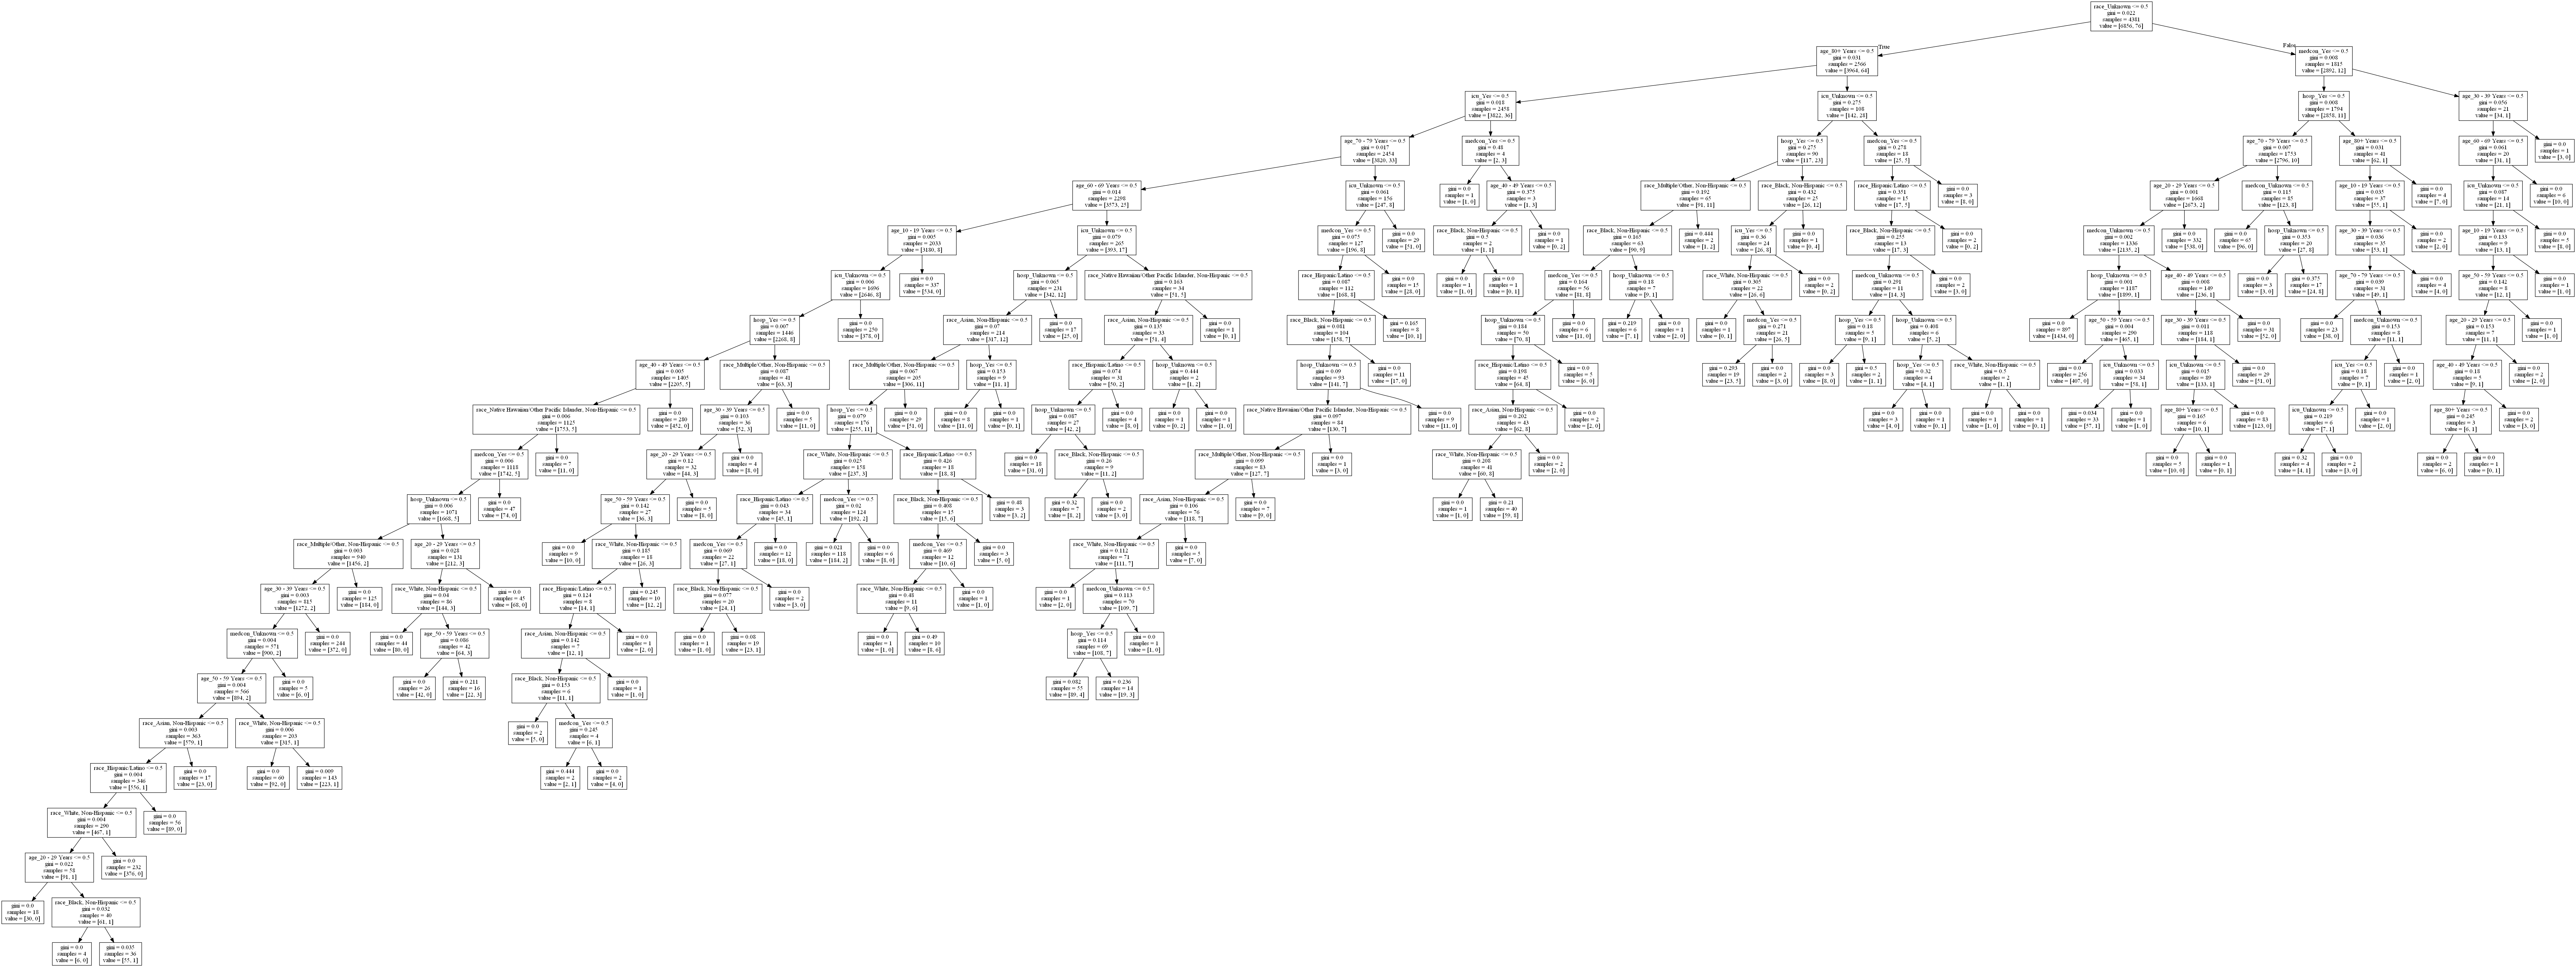

## Text decision Tree

In [125]:
"""
treeviz.py

A simple tree visualizer for sklearn DecisionTreeClassifiers.

Written by Lutz Hamel, (c) 2017 - Univeristy of Rhode Island
"""
import operator

def tree_print(clf, X):
    """
    Print the tree of a sklearn DecisionTreeClassifier

    Parameters
    ----------
    clf : DecisionTreeClassifier - A tree that has already been fit.
    X : The original training set
    """
    tlevel = _tree_rprint('', clf, X.columns, clf.classes_)
    print('<',end='')
    for i in range(3*tlevel - 2):
        print('-',end='')
    print('>')
    print('Tree Depth: ',tlevel)

def _tree_rprint(kword, clf, features, labels, node_index=0, tlevel_index=0):
    # Note: The DecisionTreeClassifier uses the Tree structure defined in:
    # 		github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx
    #       it is an array based tree implementation:

    # indent the nodes according to their tree level
    for i in range(tlevel_index):
        print('  |',end='')

	#  TODO: the following should use the TREE_LEAF constant defined in _tree.pyx
	#        instead of -1, not quite sure how to get at it from the tree user level
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        print(kword, end=' ' if kword else '')
        # get the majority label
        count_list = clf.tree_.value[node_index, 0]
        max_index, max_value = max(enumerate(count_list), key=operator.itemgetter(1))
        max_label = labels[max_index]
        print(max_label)
        return tlevel_index
    
    else:
        # compute and print node label
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        print(kword, end=' ' if kword else '')
        print('if {} =< {}: '.format(feature, threshold))
        # recurse down the children
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        ltlevel_index = _tree_rprint('then', clf, features, labels, left_index, tlevel_index+1)
        rtlevel_index = _tree_rprint('else', clf, features, labels, right_index, tlevel_index+1)
        # return the maximum depth of either one of the children
        return max(ltlevel_index,rtlevel_index)

In [251]:
# tree_print(random_forest_train[0], X)
# This prints the text based decision tree, its pretty large so i left it commented just for ease of readability

### Above are the png and Text version of the first decision tree from the Random forest model.

As seen in this Decision tree the root node is race_Unknown. If the value is less than (or equal to) .5 (i.e the race isnt Unknown) then the  next node "asks" if the age is 80 or not. This continues until a final value is reached.

As shown in the trees above the vast majority of paths terminate with the value of 0.0 (Alive). This again highlights the possible issues that were also apparant in the multiple linear and logistic regressions. Mainly that the minority case (Death) in the data is underrepresented 


As this is a random forest model it consists of multiple decision trees which could (theoretically) vary greatly from this however going through 100 trees would make this report waaaay too long. 

# (3.3) 
- Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [127]:
predicted

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,...,race_Hispanic/Latino,"race_Multiple/Other, Non-Hispanic","race_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_Unknown,"race_White, Non-Hispanic",hosp_Unknown,hosp_Yes,death_Yes,medcon_Unknown,medcon_Yes
9249,2020-12-24,2020-12-24,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
1176,2021-01-12,2021-01-27,2021-01-12,NaT,Laboratory-confirmed case,Male,0 - 9 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
1450,2020-12-19,2020-12-19,2020-12-20,2020-12-19,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Unknown,...,0,0,0,1,0,0,0,0,0,1
7126,2020-10-27,2020-11-03,2020-10-27,2020-10-27,Laboratory-confirmed case,Female,0 - 9 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0
2210,2020-11-21,2021-01-27,NaT,2020-11-21,Laboratory-confirmed case,Male,60 - 69 Years,Hispanic/Latino,No,No,...,1,0,0,0,0,0,0,0,0,0
252,2021-01-05,NaT,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,"Multiple/Other, Non-Hispanic",Unknown,No,...,0,1,0,0,0,1,0,0,0,0
2165,2020-10-11,2020-12-22,2020-10-16,2020-10-11,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,1,0
8928,2020-10-08,2020-10-08,2020-10-08,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Unknown,...,0,0,0,1,0,1,0,0,1,0
6266,2020-07-13,2020-07-13,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,Hispanic/Latino,No,No,...,1,0,0,0,0,0,0,0,0,0
2433,2020-11-10,2020-11-10,NaT,2020-11-10,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",No,No,...,0,0,0,0,1,0,0,0,0,0


In [128]:
random_forest_predictions = random_forest_train.predict(predicted[features])
random_forest_actual_vs_predicted = pd.DataFrame({"Actual":df_all.death_Yes.head(10), "Predicted": random_forest_predictions})
random_forest_actual_vs_predicted 

,Actual,Predicted
9249,0,0
1176,0,0
1450,0,0
7126,0,0
2210,0,0
252,0,0
2165,0,0
8928,0,0
6266,0,0
2433,0,0


In [129]:
print("Accuracy: ", metrics.accuracy_score(y, random_forest_train.predict(X)))
print("Confusion matrix: \n", metrics.confusion_matrix(y, random_forest_train.predict(X)))
print("Classification report:\n ", metrics.classification_report(y, random_forest_train.predict(X)))

Accuracy:  0.9774924253354494
Confusion matrix: 
 [[6640   53]
 [ 103  135]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6693
           1       0.72      0.57      0.63       238

    accuracy                           0.98      6931
   macro avg       0.85      0.78      0.81      6931
weighted avg       0.98      0.98      0.98      6931



### Above is the classification report for the Random forest model based on the training data

As was the case with the previous two models the random forest shows a high f1 score with regards to negative instances of the target variable (alive) but that falls when the target outcome is positive (death). Like the previous models the drop is more significant in recall for the positve instances of the target feature. 

However this drop in recall and f1 is less significant then the other models indicating that this model is more accurate.

# (3.4) 
- Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and to the out-of-sample error and discuss your findings.

## Validation on hold out data

In [130]:
print("Accuracy: ", metrics.accuracy_score(y_test, random_forest_train.predict(X_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, random_forest_train.predict(X_test)))
print("Classification report:\n ", metrics.classification_report(y_test, random_forest_train.predict(X_test)))

Accuracy:  0.9633120161561763
Confusion matrix: 
 [[2819   43]
 [  66   43]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.98      0.98      2862
           1       0.50      0.39      0.44       109

    accuracy                           0.96      2971
   macro avg       0.74      0.69      0.71      2971
weighted avg       0.96      0.96      0.96      2971



### Above is the classification metrics of the random forest model on the hold out data

As was shown before the models f1 score is much greater when the predicted target outcome is negative (alive) but again this falls sharply when the target feature should be positive (Dead). This diffirence is even greater then the metrics on the training data

The most signficant drop is in recall for the postive instances of the target feature, indicating that there are a large amount of false negatives in the prediction models output

## Cross validation with Whole dataset trained random forest

In [131]:
full_rfc= RandomForestClassifier(n_estimators=100, max_features="auto", oob_score=True, random_state=1)

In [132]:
full_rfc.fit(X_full,y_full)

RandomForestClassifier(oob_score=True, random_state=1)

In [133]:
pd.DataFrame({"Feature":X_full.columns,"Importance":full_rfc.feature_importances_})

,Feature,Importance
0,age_10 - 19 Years,0.003856
1,age_20 - 29 Years,0.013299
2,age_30 - 39 Years,0.013675
3,age_40 - 49 Years,0.012536
4,age_50 - 59 Years,0.017149
5,age_60 - 69 Years,0.021142
6,age_70 - 79 Years,0.052477
7,age_80+ Years,0.247253
8,icu_Unknown,0.043531
9,icu_Yes,0.091364


In [134]:
rfc_predictions = full_rfc.predict(X_full)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_full, 'PredictedClass': rfc_predictions})
df_true_vs_rfc_predicted

,ActualClass,PredictedClass
9249,0,0
1176,0,0
1450,0,0
7126,0,0
2210,0,0
...,...,...
4417,0,0
8716,0,0
9915,0,0
4083,0,0


In [135]:
print("Accuracy: ", metrics.accuracy_score(y_full, rfc_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y_full, rfc_predictions))
print("Classification report:\n ", metrics.classification_report(y_full, rfc_predictions))

Accuracy:  0.9755604928297313
Confusion matrix: 
 [[9485   70]
 [ 172  175]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      9555
           1       0.71      0.50      0.59       347

    accuracy                           0.98      9902
   macro avg       0.85      0.75      0.79      9902
weighted avg       0.97      0.98      0.97      9902



### Above is the classification metrics of the random forest trained on the whole data set.

AS was the case with the other models  f1 score is much greater when the predicted target outcome is negative (alive) but again this falls sharply when the target feature should be positive (Dead). This will be discussed further in part 5

An intresting point to note is that the whole dataset model has a higher overall F1 score then the previous model

# Part 5

# 5.1
- Which model of the ones trained above performs better at predicting the target feature? Is it more   accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers.

### Multiple Linear regression

In [136]:
print("Multiple Linear Regression")
printMetrics(y, covid_linreg_predictions)
printClassMetrics(actual_vs_predicted_linreg["death_Yes"], actual_vs_predicted_linreg["Predicted"])

Multiple Linear Regression

MAE:  0.05324508318002087
RMSE:  0.15098522190374425
R2:  0.3125155193001091

Confusion Matrix:  [[6667   26]
 [ 189   49]]
Accuracy:  0.9689799451738565
Precision Score  0.6533333333333333
F1 0.31309904153354634
Recall Score 0.20588235294117646


### Logistical Regression

In [137]:
printMetrics(y, y_pred)
print(classification_report(y, y_pred))
print("Confusion matrix: \n", metrics.confusion_matrix(y, y_pred))


MAE:  5.6730630500649255
RMSE:  0.17156043324042713
R2:  0.11237753729909683
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6693
           1       0.63      0.35      0.45       238

    accuracy                           0.97      6931
   macro avg       0.80      0.67      0.72      6931
weighted avg       0.97      0.97      0.97      6931

Confusion matrix: 
 [[6643   50]
 [ 154   84]]


## Random Forest

In [138]:
print("Random Forest")
printMetrics(y, random_forest_train.predict(X))
print("Accuracy: ", metrics.accuracy_score(y, random_forest_train.predict(X)))
print("Confusion matrix: \n", metrics.confusion_matrix(y, random_forest_train.predict(X)))
print("Classification report:\n ", metrics.classification_report(y, random_forest_train.predict(X)))

Random Forest

MAE:  3.7971432693694993
RMSE:  0.15002524675717274
R2:  0.3212298814640152
Accuracy:  0.9774924253354494
Confusion matrix: 
 [[6640   53]
 [ 103  135]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6693
           1       0.72      0.57      0.63       238

    accuracy                           0.98      6931
   macro avg       0.85      0.78      0.81      6931
weighted avg       0.98      0.98      0.98      6931



## Majority Class Prediction

In [139]:
y_full

9249    0
1176    0
1450    0
7126    0
2210    0
       ..
4417    0
8716    0
9915    0
4083    0
7445    0
Name: death_Yes, Length: 9902, dtype: uint8

In [140]:
majority_df = pd.DataFrame(y_test)

In [141]:
majority_df["Majority"] = 0

In [142]:
majority_df

,death_Yes,Majority
3462,0,0
3132,0,0
5162,0,0
5781,0,0
213,1,0
...,...,...
4417,0,0
8716,0,0
9915,0,0
4083,0,0


In [143]:
print("Majority Guessing Model")
printMetrics(majority_df["death_Yes"], majority_df["Majority"])
print("Accuracy: ", metrics.accuracy_score(majority_df["death_Yes"], majority_df["Majority"]))
print("Confusion matrix: \n", metrics.confusion_matrix(majority_df["death_Yes"], majority_df["Majority"]))
print("Classification report:\n ", metrics.classification_report(majority_df["death_Yes"], majority_df["Majority"]))

Majority Guessing Model

MAE:  0.03668798384382363
RMSE:  0.1915410761268288
R2:  -0.03808525506638705
Accuracy:  0.9633120161561763
Confusion matrix: 
 [[2862    0]
 [ 109    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98      2862
           1       0.00      0.00      0.00       109

    accuracy                           0.96      2971
   macro avg       0.48      0.50      0.49      2971
weighted avg       0.93      0.96      0.95      2971



C:\Users\Samilton\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samilton\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samilton\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As the majority prediction model only picks one of the possible outcomes for the target feature precision, recall and therefore F1 are 0 for instances of a positive outcome for the target features

### The accuracy of the models

Based on the Metrics outlined above the best performing model is the random forest. This was determined for the following reasons
- Lowest RMSE
- Highest Accuracy
- Lowest amounts of errors with regards to accurate prediction when the target outcome is 1 (determined via the confusion matricies)
- Highest F1 score when the target outcome should be 1


In some areas the simple majority guessing model performed better than the prediction models:
- less overall errors as shown in the confusion matrix (because it can only make 1 type of error)
- Similar accuracy when compared to the prediction models
The Guessing model however did have a lower F1 score when the target outcome should be 1 and a lower RMSE. Based on these factors this model would perform worse on a dataset with a greater proportion of the minority cases

# Creating a better model

# (5.2) 
- Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using furher data prep such as: feature selection, feature re-scaling, creating new features, combining models, or using other knowledge)? Please show how your ideas actually work in practice, by training and evaluating your proposed models. Summarise your findings so far.

Based on the results of all three prediction models one of the key issues with the trained models is with the data that it is trained on.

Each model has a significant drop in recall when the target outcome was positive. This indicates that a large amount of false negatives were happening. This could be a result of the prediction models not having enough positive targer outcome data (i.e the models have to few examples of rows with death as the outcome to accuratly create a prediction model for it)

In [144]:
print(df_full.shape)
(df_full["death_Yes"]==1).sum()

(9902, 27)


347

This is demonstrated above. Out of 9902 entries only 347 (3.5%) are a positive instance of the target outcome. This shows that there is a significant imbalance in the dataset. There are two ways that this can be rectified
- Undersampling the majority cases
- Oversampling the minority cases

These have their own drawbacks which will be addressed later when the models are implimented

### Features
Based on the features and importance it appears that the model may benefit from a transformation of the age group feature. The rationale behind this is that agegroup represents both the one of the least important (10-19 years) and one of the most important (80+) features. There are two possible transformations that this could take
- Re-Scaling to two categories under 50 and over 50 (Split based on where the coeficients change direction in the other models)
- Creating a new feature age_approx which is a numerical representation of the mean age (e.g for 40-49 this would be 45).

#### New Feature
The new model will also be evaluated with regards to a new feature created in homework 1 . Spec before symptoms, which is a boolean value which indicates if a patients covid specimen was collected before the onset of symptoms (This will also allow a form of the date data to be used in the model and not go to waste)


### Summary

Model to be used : Random Forest (Due to its previous performance)

Changes to be made:
- Over/undersampling on the data
- Transformation of age_group data (Over 50 & Numerical approximation)
- Creation of the spec_before_symptom feature

As at least the age_group transformations would interfere with each other (both having a high correlation with each other as they are essentailly measuring the same thing) they will not be used in the same model

## Adding the new features

### Age Approx

Alterations are made on the pre-split Dataframe (less repition), This will be re-dummfied for the final models

In [145]:
df["age_approx"]= df["age_group"]

df["age_approx"].replace({"0 - 9 Years":5,"10 - 19 Years":15,"20 - 29 Years":25,"30 - 39 Years": 35, "40 - 49 Years": 45, "50 - 59 Years": 55, "60 - 69 Years": 65, "70 - 79 Years": 75, "80+ Years": 85},inplace=True)

df["age_approx"] = df["age_approx"].astype("int64")

In [146]:
#Descriptive stats
df["age_approx"].describe().T

count    9902.000000
mean       41.690568
std        20.722848
min         5.000000
25%        25.000000
50%        35.000000
75%        55.000000
max        85.000000
Name: age_approx, dtype: float64

### Age approx interactions with the target feature

In [147]:
# Using a  point biserial correlation coefficient to determine the relationship between approximate age
# and the target outcome

# Convert death_yn to a boolean numpy array
a = np.array(df["death_yn"])

a =np.where(a=="Yes",1,a)
a =np.where(a=="No",0,a)

a = a.astype(bool)

In [148]:
#Checking the conversion was successfull
print(a)
a.dtype

[False False False ... False False False]


dtype('bool')

In [149]:
# Convert age_approx to a numpy array
b = np.array(df["age_approx"])
b.dtype


dtype('int64')

In [150]:
print(stats.pointbiserialr(a, b))
print("\n")
print(stats.pearsonr(a, b))
np.corrcoef(a, b)

PointbiserialrResult(correlation=0.3071247976612678, pvalue=2.6799952902269116e-215)


(0.3071247976612678, 2.6799952902269116e-215)


array([[1.       , 0.3071248],
       [0.3071248, 1.       ]])

As shown in the correlation above there is a weak postive correlation between age and death .This indicates that as the age increases there is a corresponding increase in the likelihood of death being the outcome

In [151]:
df["age_approx"].head(10)

9249    35
1176     5
1450    45
7126     5
2210    65
252     45
2165    45
8928    55
6266    45
2433    25
Name: age_approx, dtype: int64

### New Feature: Over 50

In [152]:
df["over_50"]= ( df["age_approx"] > 50)

df["over_50"].astype("category")

9249    False
1176    False
1450    False
7126    False
2210     True
        ...  
4417     True
8716     True
9915    False
4083    False
7445    False
Name: over_50, Length: 9902, dtype: category
Categories (2, object): [False, True]

In [153]:
df["over_50"].head(10)

9249    False
1176    False
1450    False
7126    False
2210     True
252     False
2165    False
8928     True
6266    False
2433    False
Name: over_50, dtype: bool

## Plotting the Pairwise iteraction between over 50 and the target feature

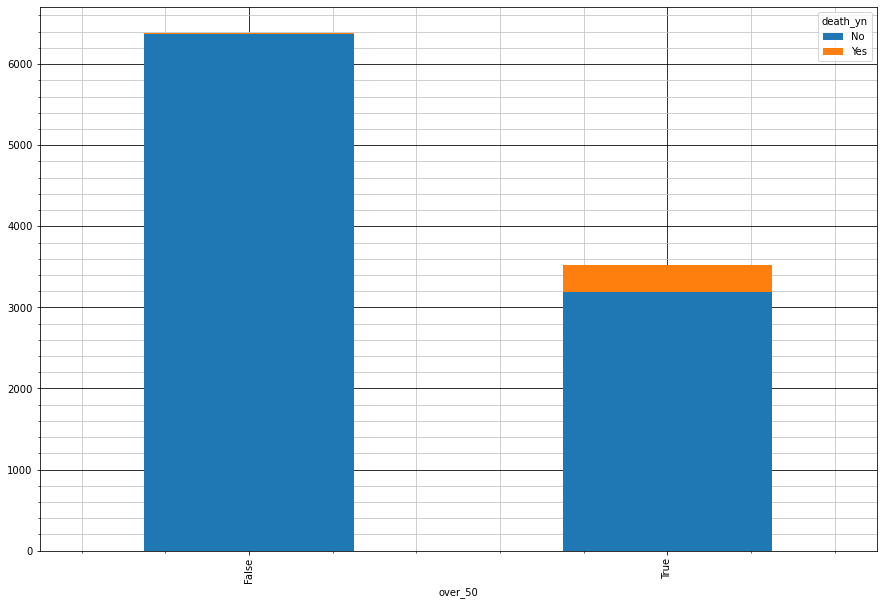

In [154]:
by_fifty= df.groupby(["over_50","death_yn"]).size()
by_fifty.unstack().plot(kind="bar",stacked = True, figsize=(15,10))

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)


As shown in the stacked barchart above there is a clear increase in positive outcomes in the target feature in the true group

### Spec_Before_Symptoms

- Measures (in boolean) if a postive specimen was collected before the onset of symptoms
- Can be used to gain a better understanding of a targeted feature as an early positive identification can be a type of early warning

In [155]:
df["spec_before_symptoms"]= ( df["onset_dt"] - df["pos_spec_dt"]).dt.days >0

df["spec_before_symptoms"].astype("category")

9249    False
1176    False
1450    False
7126    False
2210    False
        ...  
4417    False
8716    False
9915    False
4083    False
7445    False
Name: spec_before_symptoms, Length: 9902, dtype: category
Categories (2, object): [False, True]

### Plotting the pairwise interaction between spec_before_symptoms and the target feature

(0.0, 1.0)

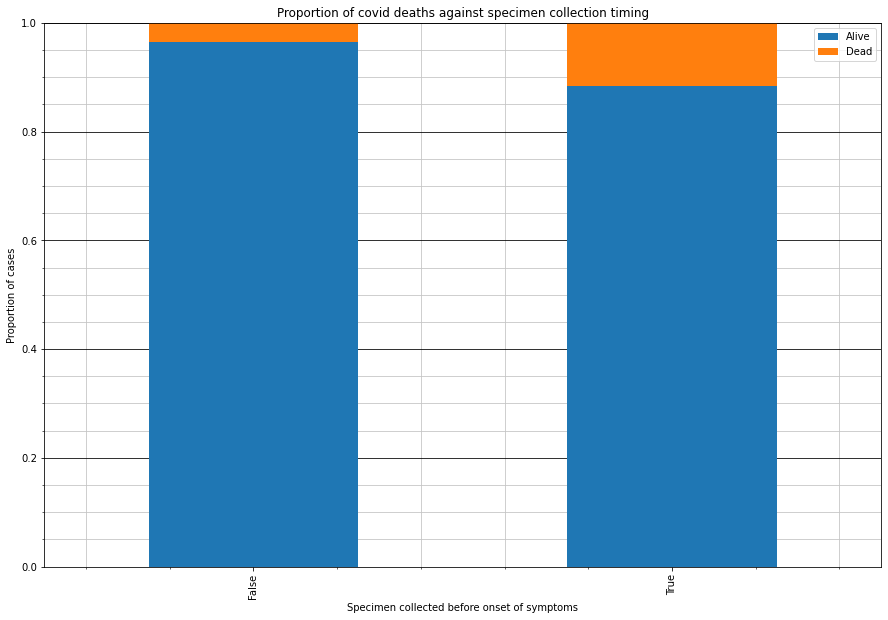

In [156]:
by_spec_time =  df.groupby(["spec_before_symptoms"]).death_yn.value_counts(normalize=True)

by_spec_time_plot=by_spec_time.unstack().plot(kind="bar",stacked = True, figsize=(15,10), title="Proportion of covid deaths against specimen collection timing")

by_spec_time_plot.set_ylabel("Proportion of cases")
by_spec_time_plot.set_xlabel("Specimen collected before onset of symptoms")

by_spec_time_plot.legend(["Alive","Dead"])

plt.grid(b=True, which="major",color="#000000",linestyle="-")
plt.minorticks_on()
plt.grid(b=True, which="minor",color="#c4c4c4",linestyle="-")
plt.rc("axes", axisbelow=True)
plt.ylim(0,1)

As seen in the stacked barchart above, there is a clear difference in the proportion of positive target feature outcomes between the groups. With a higher proportion of the True cases resulting in death

As age_approx is simply teh age_group transformed into numerical data the interactions would be the same as age_group which have been outlined previously

### Dummification (I think thats a word) of the features

In [157]:
## What the Dataframe looks like now
df.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,age_approx,over_50,spec_before_symptoms
9249,2020-12-24,2020-12-24,NaT,NaT,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",No,No,No,No,35,False,False
1176,2021-01-12,2021-01-27,2021-01-12,NaT,Laboratory-confirmed case,Male,0 - 9 Years,"White, Non-Hispanic",No,No,No,No,5,False,False
1450,2020-12-19,2020-12-19,2020-12-20,2020-12-19,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Unknown,No,Yes,45,False,False
7126,2020-10-27,2020-11-03,2020-10-27,2020-10-27,Laboratory-confirmed case,Female,0 - 9 Years,"White, Non-Hispanic",No,No,No,No,5,False,False
2210,2020-11-21,2021-01-27,NaT,2020-11-21,Laboratory-confirmed case,Male,60 - 69 Years,Hispanic/Latino,No,No,No,No,65,True,False
252,2021-01-05,NaT,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,"Multiple/Other, Non-Hispanic",Unknown,No,No,No,45,False,False
2165,2020-10-11,2020-12-22,2020-10-16,2020-10-11,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",No,No,No,Unknown,45,False,False
8928,2020-10-08,2020-10-08,2020-10-08,NaT,Laboratory-confirmed case,Male,50 - 59 Years,Unknown,Unknown,Unknown,No,Unknown,55,True,False
6266,2020-07-13,2020-07-13,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,Hispanic/Latino,No,No,No,No,45,False,False
2433,2020-11-10,2020-11-10,NaT,2020-11-10,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",No,No,No,No,25,False,False


In [158]:
icu_dummies=pd.get_dummies(df["icu_yn"],prefix="icu",drop_first=True)
race_dummies=pd.get_dummies(df["race_ethnicity_combined"],prefix="race",drop_first=True)
medcon_dummies=pd.get_dummies(df["medcond_yn"],prefix="medcon",drop_first=True)
hosp_dummies=pd.get_dummies(df["hosp_yn"],prefix="hosp",drop_first=True)
before_symptom_dummies=pd.get_dummies(df["spec_before_symptoms"],prefix="spec_before_symp",drop_first=True)
over_fifty_dummies=pd.get_dummies(df["over_50"],prefix="over_50",drop_first=True)

# Target feature dummys
death_dummy=pd.get_dummies(df["death_yn"],prefix="death",drop_first=True)

# Dataframe with the dummy values + Age in numerical
df_approx =  pd.concat([df["age_approx"],icu_dummies,race_dummies,medcon_dummies,hosp_dummies,before_symptom_dummies,death_dummy],axis=1)


# Dataframe with the age measure in over 50
df_over =  pd.concat([over_fifty_dummies,icu_dummies,race_dummies,medcon_dummies,hosp_dummies,before_symptom_dummies,death_dummy],axis=1)

### Preparing the features

In [159]:
# Adding the new dummy values to the categorical features
categ_features = before_symptom_dummies.columns.values.tolist()
categ_features += icu_dummies.columns.values.tolist()
categ_features += race_dummies.columns.values.tolist()
categ_features += hosp_dummies.columns.values.tolist()
categ_features += medcon_dummies.columns.values.tolist()

# Contigous feature(s)

cont_features= ["age_approx"]

# Features for the model using the age_approx feature
approx_features = categ_features + cont_features

print("Features for the age approx Dataframe :",approx_features)

Features for the age approx Dataframe : ['spec_before_symp_True', 'icu_Unknown', 'icu_Yes', 'race_Asian, Non-Hispanic', 'race_Black, Non-Hispanic', 'race_Hispanic/Latino', 'race_Multiple/Other, Non-Hispanic', 'race_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'race_Unknown', 'race_White, Non-Hispanic', 'hosp_Unknown', 'hosp_Yes', 'medcon_Unknown', 'medcon_Yes', 'age_approx']


In [160]:
## Features for the over 50 dataframe

categ_features += over_fifty_dummies.columns.values.tolist()

# Features for the model using the over_fifty feature
over_fifty_features = categ_features

print("Features for the over 50 Dataframe :",over_fifty_features)

Features for the over 50 Dataframe : ['spec_before_symp_True', 'icu_Unknown', 'icu_Yes', 'race_Asian, Non-Hispanic', 'race_Black, Non-Hispanic', 'race_Hispanic/Latino', 'race_Multiple/Other, Non-Hispanic', 'race_Native Hawaiian/Other Pacific Islander, Non-Hispanic', 'race_Unknown', 'race_White, Non-Hispanic', 'hosp_Unknown', 'hosp_Yes', 'medcon_Unknown', 'medcon_Yes', 'over_50_True']


### Showing the new dataframe

In [161]:
df_approx.head(5)


,age_approx,icu_Unknown,icu_Yes,"race_Asian, Non-Hispanic","race_Black, Non-Hispanic",race_Hispanic/Latino,"race_Multiple/Other, Non-Hispanic","race_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_Unknown,"race_White, Non-Hispanic",medcon_Unknown,medcon_Yes,hosp_Unknown,hosp_Yes,spec_before_symp_True,death_Yes
9249,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1176,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1450,45,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
7126,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2210,65,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [162]:
df_over.head(5)

,over_50_True,icu_Unknown,icu_Yes,"race_Asian, Non-Hispanic","race_Black, Non-Hispanic",race_Hispanic/Latino,"race_Multiple/Other, Non-Hispanic","race_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_Unknown,"race_White, Non-Hispanic",medcon_Unknown,medcon_Yes,hosp_Unknown,hosp_Yes,spec_before_symp_True,death_Yes
9249,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1176,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1450,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
7126,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2210,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [163]:
df_approx.shape

(9902, 16)

In [164]:
df_over.shape

(9902, 16)

### Random Forest Model with Age approx & Spec before symptoms

In [165]:
# Splitting into a training and test
df_Ageapprox_training=df_approx.iloc[:int(df.shape[0]*.7), :]
df_Ageapprox_test=df_approx.iloc[int(df.shape[0]*.7):,:]

# Splitting into X(predictive) and y(target)
X_age_approx = df_Ageapprox_training[approx_features]
y_age_approx = df_Ageapprox_training.death_Yes

X_age_approx_test = df_Ageapprox_test[approx_features]
y_age_approx_test = df_Ageapprox_test.death_Yes

In [166]:
random_forest_train_age_approx= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [167]:
random_forest_train_age_approx.fit(X_age_approx,y_age_approx)

# Compute the importance of each feature based on the trained decision tree classifier
pd.DataFrame({'feature': X_age_approx.columns, 'importance': random_forest_train_age_approx.feature_importances_})

,feature,importance
0,spec_before_symp_True,0.017623
1,icu_Unknown,0.038649
2,icu_Yes,0.081610
3,"race_Asian, Non-Hispanic",0.014316
4,"race_Black, Non-Hispanic",0.019042
5,race_Hispanic/Latino,0.014043
6,"race_Multiple/Other, Non-Hispanic",0.013038
7,"race_Native Hawaiian/Other Pacific Islander, N...",0.000151
8,race_Unknown,0.022320
9,"race_White, Non-Hispanic",0.022392


In [168]:
print("Accuracy: ", metrics.accuracy_score(y_age_approx, random_forest_train_age_approx.predict(X_age_approx)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_age_approx, random_forest_train_age_approx.predict(X_age_approx)))
print("Classification report:\n ", metrics.classification_report(y_age_approx, random_forest_train_age_approx.predict(X_age_approx)))

Accuracy:  0.9779252633097677
Confusion matrix: 
 [[6642   51]
 [ 102  136]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6693
           1       0.73      0.57      0.64       238

    accuracy                           0.98      6931
   macro avg       0.86      0.78      0.81      6931
weighted avg       0.98      0.98      0.98      6931



### Cross Validation with hold out data

In [262]:
print("Accuracy: ", metrics.accuracy_score(y_age_approx_test, random_forest_train_age_approx.predict(X_age_approx_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_age_approx_test, random_forest_train_age_approx.predict(X_age_approx_test)))
print("Classification report:\n ", metrics.classification_report(y_age_approx_test, random_forest_train_age_approx.predict(X_age_approx_test)))

Accuracy:  0.9629754291484349
Confusion matrix: 
 [[2817   45]
 [  65   44]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.98      0.98      2862
           1       0.49      0.40      0.44       109

    accuracy                           0.96      2971
   macro avg       0.74      0.69      0.71      2971
weighted avg       0.96      0.96      0.96      2971



Above is the cross validation scores of the Age approx and Spec before symptoms random forest model.

As with the other models there is a sharp decline in the f1 scores with regard to positive outcomes of the target feature. This drop is most apparant in the recall score of the positive group.
Based on the scores this model seems to perform more or less the same as the first random tree model.

### Random Forest model with Age approx & Spec Before Symptoms and Oversampling

#### Splitting the dataset

In [170]:
# Splitting into a training and test
df_approx_training=df_approx.iloc[:int(df.shape[0]*.7), :]
df_approx_test=df_approx.iloc[int(df.shape[0]*.7):,:]

In [171]:
#pip install delayed
# pip install imbalanced-learn
import imblearn 
from imblearn.over_sampling import SMOTE

In [172]:
# Splitting X and Y for the train and test
X_approx = df_approx_training[approx_features]
y_approx = df_approx_training.death_Yes

X_approx_test = df_approx_test[approx_features]
y_approx_test = df_approx_test.death_Yes


In [173]:
# Sampling strategy creates positive instances of target feature to .2 overall (20%)
sm= SMOTE(random_state=42, sampling_strategy = .2)
x_res, y_res = sm.fit_resample(X_approx,y_approx)

In [174]:
y_res.value_counts()

0    6693
1    1338
Name: death_Yes, dtype: int64

Above shows the oversampled minority data that will be used to train the model. This increase in the proportion of minority cases will (Hopefully) result in a model that is more accuratly able to predict when the target features is positive (death) due to the increase in examples it has been trained with

In [175]:
random_forest_trainApprox= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [176]:
random_forest_trainApprox.fit(x_res,y_res)

RandomForestClassifier(oob_score=True, random_state=1)

In [177]:
# Compute the importance of each feature based on the trained decision tree classifier
pd.DataFrame({'feature': x_res.columns, 'importance': random_forest_trainApprox.feature_importances_})

,feature,importance
0,spec_before_symp_True,0.005880
1,icu_Unknown,0.019123
2,icu_Yes,0.026410
3,"race_Asian, Non-Hispanic",0.013415
4,"race_Black, Non-Hispanic",0.019727
5,race_Hispanic/Latino,0.016327
6,"race_Multiple/Other, Non-Hispanic",0.014943
7,"race_Native Hawaiian/Other Pacific Islander, N...",0.001749
8,race_Unknown,0.023416
9,"race_White, Non-Hispanic",0.025249


Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)

In [178]:
predicted = df_approx.head(10)

random_forest_predictions = random_forest_trainApprox.predict(predicted[approx_features])
random_forest_actual_vs_predicted = pd.DataFrame({"Actual":df_approx.death_Yes.head(10), "Predicted": random_forest_predictions})
random_forest_actual_vs_predicted 

,Actual,Predicted
9249,0,0
1176,0,0
1450,0,0
7126,0,0
2210,0,0
252,0,0
2165,0,0
8928,0,0
6266,0,0
2433,0,0


In [179]:
print("Accuracy: ", metrics.accuracy_score(y_res, random_forest_trainApprox.predict(x_res)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_res, random_forest_trainApprox.predict(x_res)))
print("Classification report:\n ", metrics.classification_report(y_res, random_forest_trainApprox.predict(x_res)))

Accuracy:  0.9478271697173453
Confusion matrix: 
 [[6477  216]
 [ 203 1135]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.97      0.97      6693
           1       0.84      0.85      0.84      1338

    accuracy                           0.95      8031
   macro avg       0.90      0.91      0.91      8031
weighted avg       0.95      0.95      0.95      8031



## Above is the classification matricies for the Random forest model with Age_Approx trained on the oversampled data

As shown in the classification report the model now has an increased F1 score for both outcomes of the target feature. This shows that the model trained on the oversampled data (in theory) performs better then the models trained on the original data and is able to more accuratly predict the target outcome when it is positive (death)

## Validation on hold out data


In [180]:
print("Accuracy: ", metrics.accuracy_score(y_approx_test, random_forest_trainApprox.predict(X_approx_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_approx_test, random_forest_trainApprox.predict(X_approx_test)))
print("Classification report:\n ", metrics.classification_report(y_approx_test, random_forest_trainApprox.predict(X_approx_test)))

Accuracy:  0.9498485358465163
Confusion matrix: 
 [[2752  110]
 [  39   70]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.96      0.97      2862
           1       0.39      0.64      0.48       109

    accuracy                           0.95      2971
   macro avg       0.69      0.80      0.73      2971
weighted avg       0.96      0.95      0.96      2971



### Above is the Classification matrixis for the random forest model (with age_approx) with the hold-out data

As shown above there is a decrease in the F1(1) score when compared to the train data. However the recall and f1 score for the positive target outcome groups is higher when compared to the previous models. This indicates that the model performs slightly better then the models trained on the non-oversampled data but that the data used for training is still insufficient for a robust and accuracte model training

# Random forest with Over-50 & Spec_Before_Symptoms

In [181]:
# Splitting into a training and test
df_over_fifty_training=df_over.iloc[:int(df.shape[0]*.7), :]
df_over_fifty_test=df_over.iloc[int(df.shape[0]*.7):,:]


# Splitting X and Y for the train and test
X_over_fifty = df_over_fifty_training[over_fifty_features]
y_over_fifty = df_over_fifty_training.death_Yes

X_over_fifty_test = df_over_fifty_test[over_fifty_features]
y_over_fifty_test = df_over_fifty_test.death_Yes

In [182]:
random_forest_train_Over_Fifty= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
random_forest_train_Over_Fifty.fit(X_over_fifty,y_over_fifty)

RandomForestClassifier(oob_score=True, random_state=1)

In [183]:
pd.DataFrame({'feature': X_over_fifty.columns, 'importance': random_forest_train_Over_Fifty.feature_importances_})

,feature,importance
0,spec_before_symp_True,0.022123
1,icu_Unknown,0.040658
2,icu_Yes,0.120378
3,"race_Asian, Non-Hispanic",0.013092
4,"race_Black, Non-Hispanic",0.023919
5,race_Hispanic/Latino,0.014475
6,"race_Multiple/Other, Non-Hispanic",0.015738
7,"race_Native Hawaiian/Other Pacific Islander, N...",0.000141
8,race_Unknown,0.022039
9,"race_White, Non-Hispanic",0.020849


In [184]:
print("Accuracy: ", metrics.accuracy_score(y_over_fifty, random_forest_train_Over_Fifty.predict(X_over_fifty)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_over_fifty,random_forest_train_Over_Fifty.predict(X_over_fifty)))
print("Classification report:\n ", metrics.classification_report(y_over_fifty, random_forest_train_Over_Fifty.predict(X_over_fifty)))

Accuracy:  0.9720098109940846
Confusion matrix: 
 [[6666   27]
 [ 167   71]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6693
           1       0.72      0.30      0.42       238

    accuracy                           0.97      6931
   macro avg       0.85      0.65      0.70      6931
weighted avg       0.97      0.97      0.97      6931



### Cross validation with Hold out data

In [185]:
print("Accuracy: ", metrics.accuracy_score(y_over_fifty_test, random_forest_train_Over_Fifty.predict(X_over_fifty_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_over_fifty_test,random_forest_train_Over_Fifty.predict(X_over_fifty_test)))
print("Classification report:\n ", metrics.classification_report(y_over_fifty_test, random_forest_train_Over_Fifty.predict(X_over_fifty_test)))

Accuracy:  0.9643217771794009
Confusion matrix: 
 [[2841   21]
 [  85   24]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.99      0.98      2862
           1       0.53      0.22      0.31       109

    accuracy                           0.96      2971
   macro avg       0.75      0.61      0.65      2971
weighted avg       0.95      0.96      0.96      2971



Like the other models there is a sharp decrease in the recall and f1 scores for positive instances of the target outcome. However this change is even more dramatic then the previous models. Indicating that this model performs worse then the others.

# Random forest with Over-50 & Spec_Before_Symptoms & Oversampling

In [186]:
# Splitting into a training and test
df_over_training=df_over.iloc[:int(df.shape[0]*.7), :]
df_over_test=df_over.iloc[int(df.shape[0]*.7):,:]

In [187]:
# Splitting X and Y for the train and test
X_over = df_over_training[over_fifty_features]
y_over = df_over_training.death_Yes

X_over_test = df_over_test[over_fifty_features]
y_over_test = df_over_test.death_Yes

In [188]:
x_res_fifty, y_res_fifty = sm.fit_resample(X_over,y_over)

In [189]:
random_forest_trainOver= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
random_forest_trainOver.fit(x_res_fifty,y_res_fifty)

RandomForestClassifier(oob_score=True, random_state=1)

In [190]:
pd.DataFrame({'feature': x_res_fifty.columns, 'importance': random_forest_trainOver.feature_importances_})

,feature,importance
0,spec_before_symp_True,0.018096
1,icu_Unknown,0.045236
2,icu_Yes,0.054827
3,"race_Asian, Non-Hispanic",0.004780
4,"race_Black, Non-Hispanic",0.009674
5,race_Hispanic/Latino,0.012235
6,"race_Multiple/Other, Non-Hispanic",0.006506
7,"race_Native Hawaiian/Other Pacific Islander, N...",0.000210
8,race_Unknown,0.014396
9,"race_White, Non-Hispanic",0.013775


In [191]:
# Predicted Target for first 10 items

predicted = df_over.head(10)

random_forest_over_predictions = random_forest_trainOver.predict(predicted[over_fifty_features])
random_forest_actual_vs_predicted = pd.DataFrame({"Actual":df_over.death_Yes.head(10), "Predicted": random_forest_over_predictions})
random_forest_actual_vs_predicted 

,Actual,Predicted
9249,0,0
1176,0,0
1450,0,0
7126,0,0
2210,0,0
252,0,0
2165,0,0
8928,0,0
6266,0,0
2433,0,0


In [192]:
print("Accuracy: ", metrics.accuracy_score(y_res_fifty, random_forest_trainOver.predict(x_res_fifty)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_res_fifty,random_forest_trainOver.predict(x_res_fifty)))
print("Classification report:\n ", metrics.classification_report(y_res_fifty, random_forest_trainOver.predict(x_res_fifty)))

Accuracy:  0.9275308180799402
Confusion matrix: 
 [[6479  214]
 [ 368  970]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.97      0.96      6693
           1       0.82      0.72      0.77      1338

    accuracy                           0.93      8031
   macro avg       0.88      0.85      0.86      8031
weighted avg       0.93      0.93      0.93      8031



### Above is the classification matricies for the Random forest model with over-50 feature and oversampling

As was the case with the Age approx model there is a clear increase in the F1 score with regards to the positive outcome of the target feature when compared to the non-sampled models. Thought this improvement is less significant then the age_approx model

## Validation on hold out data


In [193]:
print("Accuracy: ", metrics.accuracy_score(y_over_test, random_forest_trainOver.predict(X_over_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_over_test, random_forest_trainOver.predict(X_over_test)))
print("Classification report:\n ", metrics.classification_report(y_over_test, random_forest_trainOver.predict(X_over_test)))

Accuracy:  0.9441265567149109
Confusion matrix: 
 [[2747  115]
 [  51   58]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.96      0.97      2862
           1       0.34      0.53      0.41       109

    accuracy                           0.94      2971
   macro avg       0.66      0.75      0.69      2971
weighted avg       0.96      0.94      0.95      2971



As was the case with the Age approx model the significant increase in F1(1) score is reduced dramatically when the model is validated on the hold-out data. This again indicates that the issue with the models is that the data used is greatly imbalanced with regard to the target outcome.

While this model performs better then the non-oversampled over 50 model it performs worse then the other models.


While oversampling does seem to result in some slight improvement in the models accuracy the fact that so little positive outcomes are present in the data, and that the oversampled samples are based on the existing data is leading the models to be overfitted and thus they struggle to accuractly predict target outcomes on "fresh" data.

As the dataset which uses age_approx has a  better F1(1) score it will be used for the undersampled method

# Random forest model with Age_approx, spec_before_symptoms and Undersampling

In [194]:
from imblearn.under_sampling import RandomUnderSampler

# Sampling strategy removes entries with negative instances of the target feature until the positve and negatives are equal
undersample = RandomUnderSampler(sampling_strategy=1)

In [195]:
# Splitting X and Y for the train and test
X_approx_under = df_approx_training[approx_features]
y_approx_under = df_approx_training.death_Yes

X_approx_under_test = df_approx_test[approx_features]
y_approx_under_test = df_approx_test.death_Yes


In [196]:
X_approx_under,y_approx_under = undersample.fit_resample(X_approx_under,y_approx_under)

In [197]:
print(X_approx_under.shape)
print(y_approx_under.shape)

(476, 15)
(476,)


In [198]:
random_forest_trainUnder= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
random_forest_trainUnder.fit(X_approx_under,y_approx_under)

RandomForestClassifier(oob_score=True, random_state=1)

In [199]:
pd.DataFrame({'feature': X_approx_under.columns, 'importance': random_forest_trainUnder.feature_importances_})

,feature,importance
0,spec_before_symp_True,0.006029
1,icu_Unknown,0.022714
2,icu_Yes,0.026801
3,"race_Asian, Non-Hispanic",0.009713
4,"race_Black, Non-Hispanic",0.013799
5,race_Hispanic/Latino,0.009545
6,"race_Multiple/Other, Non-Hispanic",0.004368
7,"race_Native Hawaiian/Other Pacific Islander, N...",0.000000
8,race_Unknown,0.018521
9,"race_White, Non-Hispanic",0.017630


In [200]:
# Predicted Target for first 10 items

predicted = df_approx.head(10)

random_forest_under_predictions = random_forest_trainUnder.predict(predicted[approx_features])
random_forest_actual_vs_predicted = pd.DataFrame({"Actual":df_approx.death_Yes.head(10), "Predicted": random_forest_under_predictions})
random_forest_actual_vs_predicted 

,Actual,Predicted
9249,0,0
1176,0,0
1450,0,0
7126,0,0
2210,0,0
252,0,0
2165,0,0
8928,0,0
6266,0,0
2433,0,0


In [201]:
print("Accuracy: ", metrics.accuracy_score(y_approx_under, random_forest_trainUnder.predict(X_approx_under)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_approx_under,random_forest_trainUnder.predict(X_approx_under)))
print("Classification report:\n ", metrics.classification_report(y_approx_under, random_forest_trainUnder.predict(X_approx_under)))

Accuracy:  0.9411764705882353
Confusion matrix: 
 [[227  11]
 [ 17 221]]
Classification report:
                precision    recall  f1-score   support

           0       0.93      0.95      0.94       238
           1       0.95      0.93      0.94       238

    accuracy                           0.94       476
   macro avg       0.94      0.94      0.94       476
weighted avg       0.94      0.94      0.94       476



### Cross validation with the Hold out data

In [202]:
print("Accuracy: ", metrics.accuracy_score(y_approx_under_test, random_forest_trainUnder.predict(X_approx_under_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_approx_under_test,random_forest_trainUnder.predict(X_approx_under_test)))
print("Classification report:\n ", metrics.classification_report(y_approx_under_test, random_forest_trainUnder.predict(X_approx_under_test)))

Accuracy:  0.8815213732749916
Confusion matrix: 
 [[2518  344]
 [   8  101]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      0.88      0.93      2862
           1       0.23      0.93      0.36       109

    accuracy                           0.88      2971
   macro avg       0.61      0.90      0.65      2971
weighted avg       0.97      0.88      0.91      2971



Above is the cross validation metrics for the Random forest model trained on undersampled data. This model (again) suffers from the same drawbacks as the others (Reduced F1 score with a positive feature outcome) But in this model the issue is with precision and not recall, indicating that the issue with this model (and thus undersampling the data) is that it leads to an increase in false positives

# Combining Under and OverSampling 

In researching possible solutions to the above validation issues  it appears that combining under and oversampling in order to reduce bias in both the minority and majority cases (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/). A model trained on data with this logic is provided below

As the oversampled dataset had an issue with low recall for positive outcomes and the undersampled model had an issue with low precision for positive target outcomes, the model may benefit from a happy middle ground between the two

In [203]:
# Splitting X and Y for the train and test
X_combo = df_approx_training[approx_features]
y_combo = df_approx_training.death_Yes

X_combo_test = df_approx_test[approx_features]
y_combo_test = df_approx_test.death_Yes


In [204]:
y_combo.shape

(6931,)

In [205]:
sm= SMOTE(random_state=42, sampling_strategy = .1)
X_res_combo, y_res_combo = sm.fit_resample(X_approx,y_approx)

In [206]:
print(X_res_combo.shape)
print(y_res_combo.value_counts())

(7362, 15)
0    6693
1     669
Name: death_Yes, dtype: int64


In [207]:
undersample = RandomUnderSampler(sampling_strategy=.5)
X_combo_under,y_combo_under = undersample.fit_resample(X_res_combo,y_res_combo)

In [208]:
print(X_combo_under.shape)
print(y_combo_under.shape)

(2007, 15)
(2007,)


In [209]:
random_forest_trainCombo= RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
random_forest_trainCombo.fit(X_combo_under,y_combo_under)

RandomForestClassifier(oob_score=True, random_state=1)

In [210]:
pd.DataFrame({'feature': X_combo_under.columns, 'importance': random_forest_trainCombo.feature_importances_})

,feature,importance
0,spec_before_symp_True,0.005759
1,icu_Unknown,0.016808
2,icu_Yes,0.019237
3,"race_Asian, Non-Hispanic",0.010764
4,"race_Black, Non-Hispanic",0.016278
5,race_Hispanic/Latino,0.017750
6,"race_Multiple/Other, Non-Hispanic",0.015171
7,"race_Native Hawaiian/Other Pacific Islander, N...",0.001358
8,race_Unknown,0.027458
9,"race_White, Non-Hispanic",0.023332


In [211]:
print("Accuracy: ", metrics.accuracy_score(y_combo_under, random_forest_trainCombo.predict(X_combo_under)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_combo_under,random_forest_trainCombo.predict(X_combo_under)))
print("Classification report:\n ", metrics.classification_report(y_combo_under, random_forest_trainCombo.predict(X_combo_under)))

Accuracy:  0.9412057797708022
Confusion matrix: 
 [[1267   71]
 [  47  622]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.95      0.96      1338
           1       0.90      0.93      0.91       669

    accuracy                           0.94      2007
   macro avg       0.93      0.94      0.93      2007
weighted avg       0.94      0.94      0.94      2007



## Validation with the hold out data

In [212]:
print("Accuracy: ", metrics.accuracy_score(y_combo_test, random_forest_trainCombo.predict(X_combo_test)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_combo_test,random_forest_trainCombo.predict(X_combo_test)))
print("Classification report:\n ", metrics.classification_report(y_combo_test, random_forest_trainCombo.predict(X_combo_test)))

Accuracy:  0.9124873779872097
Confusion matrix: 
 [[2619  243]
 [  17   92]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.92      0.95      2862
           1       0.27      0.84      0.41       109

    accuracy                           0.91      2971
   macro avg       0.63      0.88      0.68      2971
weighted avg       0.97      0.91      0.93      2971



Above is the Classification results for the random forest model trained on the combined Over and Undersampled data. As with the previous models the improvement in F1(1) score is significantly reduced when the model views "fresh" data. However this drop is less significant then the Undersampled only model. Indicating that this form of data sampling could be more effective then just undersampling or oversampling in unbalanced datasets. 



## Model Comparison Summary

All Classification reports are based on the cross-validation with the hold out data

In [213]:
decorator = "\n ================================================================="
print("Random Forest model with No new features or Under/Oversampling")
print("Classification report:\n ", metrics.classification_report(y_test, random_forest_train.predict(X_test)))
print(decorator)
print("Random Forest model with age_approx & spec_before Symptoms")
print("Classification report:\n ", metrics.classification_report(y_age_approx_test, random_forest_train_age_approx.predict(X_age_approx_test)))
print(decorator)
print("Random Forest model with age_approx & spec_before Symptoms with Oversampling")
print("Classification report:\n ", metrics.classification_report(y_approx_test, random_forest_trainApprox.predict(X_approx_test)))
print(decorator)
print("Random Forest model with over_50 & spec_before Symptoms")
print("Classification report:\n ", metrics.classification_report(y_over_fifty_test, random_forest_train_Over_Fifty.predict(X_over_fifty_test)))
print(decorator)
print("Random Forest model with over_50 & spec_before Symptoms with Oversampling")
print("Classification report:\n ", metrics.classification_report(y_over_test, random_forest_trainOver.predict(X_over_test)))
print(decorator)
print("Random Forest model with age_approx & spec_before Symptoms with Undersampling")
print("Classification report:\n ", metrics.classification_report(y_approx_under_test, random_forest_trainUnder.predict(X_approx_under_test)))
print(decorator)
print("Random Forest model with age_approx & spec_before Symptoms with Undersampling and Oversampling")
print("Classification report:\n ", metrics.classification_report(y_combo_test, random_forest_trainCombo.predict(X_combo_test)))
print(decorator)

Random Forest model with No new features or Under/Oversampling
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.98      0.98      2862
           1       0.50      0.39      0.44       109

    accuracy                           0.96      2971
   macro avg       0.74      0.69      0.71      2971
weighted avg       0.96      0.96      0.96      2971


Random Forest model with age_approx & spec_before Symptoms
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.98      0.98      2862
           1       0.49      0.40      0.44       109

    accuracy                           0.96      2971
   macro avg       0.74      0.69      0.71      2971
weighted avg       0.96      0.96      0.96      2971


Random Forest model with age_approx & spec_before Symptoms with Oversampling
Classification report:
                precision    recall  f1-score   support

           0   

Above is the classification report for each of the Random forest models.

As can be seen in the accuracy and F1(0) scores all models performed braodly similarly to each other. Each model had a high f1 score when the target outcome was negative (Alive) but each fell significantly when the target outcome was positive (Dead)

There was also some variation in each models accuracy. This can be seen in the contrast between the most accurate (Random Forest model with age_approx & spec_before Symptoms) and the least accurate (Random Forest model with age_approx & spec_before Symptoms with Undersampling)

As the goal of these prediciton models is to predict if an individuals case would result in death based on a variety of factors the model chosen for the final part of this assignment is selected based on their overall F1 scores.

This was chosen as in the real world this dataset would inheriently have an imbalance (more people survive covid-19 then die) and therefore accuracy would not be a sufficient sole measure.

Based on its F1 score when the target outcome is positive the model selected for part 5.3 is the Random Forest model with age_approx & spec_before Symptoms with Undersampling and Oversamplin (Random Forest model with age_approx & spec_before Symptoms with Oversamplin has a similar F1-score but was discounted due to its worse recall score, a score which would be important when predicting the outcome of a disease)




# (5.3) 

- Take your best model trained and selected based on past data (ie your cleaned Homework1 dataset), and evaluate it on the new test dataset provided with this homework (in file '24032021-covid19-cdc-deathyn-recent-10k.csv'). Discuss your findings.  

## Cleaning and formatting the data

This is basically identical to the data cleaning that occured in the first part of this notebook

In [214]:
df = pd.read_csv("24032021-covid19-cdc-deathyn-recent-10k.csv")

In [215]:
df.shape


(10000, 12)

In [216]:
df.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021/01/22,2021/01/22,NaN,NaN,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Missing,No,Missing
1,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Missing,No,Missing
2,2021/02/03,2021/02/05,NaN,2021/02/03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Missing,Missing,No,Missing
3,2021/02/05,2021/02/05,2021/02/07,2021/02/05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021/01/27,2021/01/27,NaN,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Missing,No,Missing
5,2021/02/07,2021/02/07,2021/02/07,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
6,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Missing,No,Missing
7,2021/02/04,NaN,NaN,NaN,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",Missing,Missing,No,Missing
8,2021/01/23,NaN,NaN,NaN,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Unknown,Missing,No,Missing
9,2021/01/25,2021/01/27,NaN,2021/01/25,Probable Case,Female,70 - 79 Years,"White, Non-Hispanic",No,Missing,No,Missing


## Converting the Date to datetime (Needed for spec_before_symptom logic

In [217]:
df["cdc_case_earliest_dt"]=pd.to_datetime(df["cdc_case_earliest_dt"],format='%Y/%m/%d')
df["cdc_report_dt"]= pd.to_datetime(df["cdc_report_dt"],format='%Y/%m/%d')
df["pos_spec_dt"]= pd.to_datetime(df["pos_spec_dt"],format='%Y/%m/%d')
df["onset_dt"]= pd.to_datetime(df["onset_dt"],format='%Y/%m/%d')

In [218]:
df.select_dtypes(include=['datetime64[ns]']).describe().T

,count,unique,top,freq,first,last
cdc_case_earliest_dt,10000,26,2021-01-20,620,2021-01-19,2021-02-13
cdc_report_dt,7835,47,2021-02-04,516,2020-07-17,2021-02-27
pos_spec_dt,2555,41,2021-01-25,170,2020-07-17,2021-02-23
onset_dt,4162,31,2021-01-25,251,2021-01-19,2021-02-27


In [219]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
cdc_report_dt              datetime64[ns]
pos_spec_dt                datetime64[ns]
onset_dt                   datetime64[ns]
current_status                     object
sex                                object
age_group                          object
race_ethnicity_combined            object
hosp_yn                            object
icu_yn                             object
death_yn                           object
medcond_yn                         object
dtype: object

## Check for constant columns

In [220]:
categorical_columns = df.select_dtypes(['object']).columns
for i in categorical_columns:
    df[i] = df[i].astype("category")
df.select_dtypes(["category"]).describe().T

,count,unique,top,freq
current_status,10000,2,Laboratory-confirmed case,8906
sex,10000,5,Female,5127
age_group,10000,10,20 - 29 Years,1730
race_ethnicity_combined,10000,9,Unknown,4128
hosp_yn,10000,4,No,4659
icu_yn,10000,4,Missing,8067
death_yn,10000,2,No,9879
medcond_yn,10000,4,Missing,7942


No constant features

### Checking for duplicate rows

In [221]:
print('Number of duplicate rows (not including first) in the dataset is: ', df.duplicated().sum())
print('Number of duplicate rows (including first) in the dataset is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate rows (not including first) in the dataset is:  1681
Number of duplicate rows (including first) in the dataset is: 2749


Duplicate rows will be kept as was the training dataset and this could just be patients with similar information rather then the same patient entered multiple times

## Finding the sum of problematic entries

In [222]:
(df["age_group"]=="Unknown").sum()

0

In [223]:
# Sum of entries where value of sex feature is Unknown
(df["sex"] == "Unknown").sum()

73

In [224]:
# Sum of entries where value of sex feature is Missing
(df["sex"] == "Missing").sum()

11

In [225]:
# Sum of entries where value of sex feature is Unknown
(df["sex"] == "Other").sum()

1

In [226]:
# Sum of entries where value of hosp_yn feature is Unknown
(df["hosp_yn"]=="Unknown").sum()

2187

In [227]:
# Sum of entries where value of icu_yn feature is Unknown
(df["icu_yn"]=="Unknown").sum()

1391

In [228]:
# Sum of entries where value of icu_yn feature is Unknown and hosp_yn isnt unknown
((df["icu_yn"] == "Unknown") & (df["hosp_yn"] != "Unknown")).sum()

587

In [229]:
# Sum of entries where value of icu_yn feature isnt Unknown and hosp_yn is unknown
((df["icu_yn"] != "Unknown") & (df["hosp_yn"] == "Unknown")).sum()

1383

## Logical Consistency

In [230]:
#Sum the rows where icu status is yes but hosp status is missing or unknown
((df["icu_yn"] == "Yes") & (df["hosp_yn"] == "Missing")).sum()


0

In [231]:
((df["icu_yn"] == "Yes") & (df["hosp_yn"] == "Unknown")).sum()

0

No rows found with positive icu status and unknown/missing hosp status. This allows us to infer that the missingvalues for hospital admission are the equivalent of a NULL value, as cases cannot be in the ICU without first going to the hospital.

In [232]:
((df["icu_yn"] == "Unknown") & (df["hosp_yn"] == "Unknown")).sum()

804

In [233]:
((df["icu_yn"] == "Missing") & (df["hosp_yn"] == "Yes")).sum()

201

In [234]:
((df["icu_yn"] == "Missing") & (df["hosp_yn"] == "No")).sum()

3729

# Data Quality Plan

## The initial issues identified within the data

- Duplicate rows
- Missing and unknown values in sex
- Missing ICU data
- Race and ethniciy column, Nearly 50% of the data is missing or unknown
- Missing data in age_group
- Missing and unknown data in medcond
- Unknown hospital values
- Unknown ICU values



## Proposed Solutions

1. *Duplicate rows*
* These rows will be kept as analysis of the content indicates that these are patients with similar features and not multiple entries for the same patient

2. *Missing unknown & Other Sex*
 * As these rows make up a very small percentage of the overall data these can be safely dropped with little to no impact. There is no predictive value on the target as Unknown and Missing are errors within the data collection (e.g There is little value is showing the percentage of death among the Unknown sex as that doesnt exist).
 
 * As there is only 1 entry with Other as a value this will be dropped as there is no logical conversion possible and there is little predictive value with only one entry
 


3. *Missing ICU data*
 * Based on the included form (pui-form.pdf) it can be safe to assume that missing in this instance means that the appropriate areas on the form were not completed. This can then be taken to defaulting to No as a result of user error (Leaving it blank rather then marking no). Conversion to No is then appropriate

4. *Race and ethnicity Column*
 * as Unknown or Missing makes up nearly half of the data for this column, these will be combined into one unknown value.
 
 * This was chosen to allow for data analysis based on Race/ethnicity


5. *Missing age_group*
* As these rows make up a very small percentage of the overall data these can be safely dropped with little to no impact

* there would be no use in leaving the data in as a predictor of the target as Missing is a data error and not a valid category

* There is also no other column with which to infer the correct age_group so conversion would not be appropriate either

6. *Missing and unknown data in medcond*
 * Rows with the "Unknown" value will be kept as an unknown vale indicator.
 
* Based on the included form (pui-form.pdf) it can be safe to assume that missing in this instance means that the appropriate areas on the form were not completed. Therefore it would be appropriate to convert these to "No"

7. *"Unknown" value for hospital*
 * These rows will be kept as an unknown value indicator


8. *"Unknown" value for ICU*
 * These rows will be kept as an unknown value indicator
 



In [235]:
# Replace Missing and unknown in the Sex feature with a dummy value "A"
df["sex"].replace({"Missing":"A"},inplace=True)
df["sex"].replace({"Unknown":"A"},inplace=True)
df["sex"].replace({"Other":"A"},inplace=True)


# include only the rows where sex does not equal the A dummy value
df = df[df.sex != "A"]


In [236]:
#Replaces instances of "Missing" in icu_yn with "No"
df["icu_yn"].replace({"Missing":"No"},inplace=True)

In [237]:
#Converts the missing values in race/ethnicity with a single Unknown value 
df["race_ethnicity_combined"].replace({"Missing":"Unknown"},inplace=True)

In [238]:
# Change missing value in the age_group column to a dummy value "A", again this was the only way to prevent further issues with charts
df["age_group"].replace({"Missing":"A"},inplace=True)
df = df[df.age_group != "A"]

### Missing and Unknown data for medcond_yn

In [239]:
print("Values to change",np.sum(df["medcond_yn"]=="Missing"))

Values to change 7854


In [240]:
#Replace values
df["medcond_yn"].replace({"Missing":"No"},inplace=True)

### Unknown values for hospital

In [241]:
print("Values to change",np.sum(df["hosp_yn"]=="Missing"))

Values to change 2730


In [242]:
df["hosp_yn"].replace({"Missing":"No"},inplace=True)

In [243]:
# Give the first 10 entries a check just to make sure its all working OK
df.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021-01-22,2021-01-22,NaT,NaT,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,No,No,No
1,2021-01-26,NaT,NaT,NaT,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,No,No,No
2,2021-02-03,2021-02-05,NaT,2021-02-03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",No,No,No,No
3,2021-02-05,2021-02-05,2021-02-07,2021-02-05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021-01-27,2021-01-27,NaT,NaT,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,No,No,No
5,2021-02-07,2021-02-07,2021-02-07,NaT,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
6,2021-01-26,NaT,NaT,NaT,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,No,No,No
7,2021-02-04,NaT,NaT,NaT,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",No,No,No,No
8,2021-01-23,NaT,NaT,NaT,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Unknown,No,No,No
9,2021-01-25,2021-01-27,NaT,2021-01-25,Probable Case,Female,70 - 79 Years,"White, Non-Hispanic",No,No,No,No


In [244]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
cdc_report_dt              datetime64[ns]
pos_spec_dt                datetime64[ns]
onset_dt                   datetime64[ns]
current_status                   category
sex                                object
age_group                          object
race_ethnicity_combined            object
hosp_yn                            object
icu_yn                             object
death_yn                         category
medcond_yn                         object
dtype: object

# Formatting the Data for the model

In [245]:
# Creating the age_approx feature
df["age_approx"]= df["age_group"]

df["age_approx"].replace({"0 - 9 Years":5,"10 - 19 Years":15,"20 - 29 Years":25,"30 - 39 Years": 35, "40 - 49 Years": 45, "50 - 59 Years": 55, "60 - 69 Years": 65, "70 - 79 Years": 75, "80+ Years": 85},inplace=True)

df["age_approx"] = df["age_approx"].astype("int64")

#Creating the spec_before_symptoms feature

df["spec_before_symptoms"]= ( df["onset_dt"] - df["pos_spec_dt"]).dt.days >0

df["spec_before_symptoms"].astype("category")


# Creating the dummies
icu_dummies=pd.get_dummies(df["icu_yn"],prefix="icu",drop_first=True)
race_dummies=pd.get_dummies(df["race_ethnicity_combined"],prefix="race",drop_first=True)
medcon_dummies=pd.get_dummies(df["medcond_yn"],prefix="medcon",drop_first=True)
hosp_dummies=pd.get_dummies(df["hosp_yn"],prefix="hosp",drop_first=True)
before_symptom_dummies=pd.get_dummies(df["spec_before_symptoms"],prefix="spec_before_symp",drop_first=True)

# Target feature dummys
death_dummy=pd.get_dummies(df["death_yn"],prefix="death",drop_first=True)

# Dataframe with the dummy values + Age in numerical
df_new =  pd.concat([df["age_approx"],icu_dummies,race_dummies,medcon_dummies,hosp_dummies,before_symptom_dummies,death_dummy],axis=1)


In [247]:
# Splitting the new and formatted dataframe into X(predictors) and y(target)
X_new = df_new[approx_features]
y_new= df_new.death_Yes

In [248]:
print("Accuracy: ", metrics.accuracy_score(y_new, random_forest_trainCombo.predict(X_new)))
print("Confusion matrix: \n", metrics.confusion_matrix(y_new,random_forest_trainCombo.predict(X_new)))
print("Classification report:\n ", metrics.classification_report(y_new, random_forest_trainCombo.predict(X_new)))

Accuracy:  0.9174997475512471
Confusion matrix: 
 [[9002  781]
 [  36   84]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      0.92      0.96      9783
           1       0.10      0.70      0.17       120

    accuracy                           0.92      9903
   macro avg       0.55      0.81      0.56      9903
weighted avg       0.99      0.92      0.95      9903



Like the models results on the over and undersampled these results indicate that the models performance decreases significantly when the target feature is positive (death). This is reflected in the models precision score. These results and the results of the previous models show that using imbalanced data to create prediction models comes with some significant drawbacks with regards to accurate predictions.

As was previously outlined the lack of entries with a positive target outcome leads to a model which is unable to accuratly predict when the target outcome is positive. While this shortcoming can be somewhat compensated for with over and/or undersampling this can lead to overfitting of the model and thus lead to greater innaccuracies.


#### Packages used

In [264]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'pandas',
 'matplotlib.pyplot',
 'numpy',
 'sklearn',
 'sklearn.metrics',
 'graphviz',
 'sklearn.tree',
 'scipy.stats',
 'operator',
 'imblearn',
 'types']